## W207 Final Project - Chest X-Ray Images (Pneumonia)

### Julian Tsang & Javed Roshan

#### Overview
This Kaggle [dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) is a labeled dataset containing black and white x-ray images of lungs. Some are healthy and some have been diagnosed with pneumonia. 
We will be using Convolutional Neural Networks for this classification problem.

[Colab Notebook](https://colab.research.google.com/drive/1kob5MbXraiQWyb0mWPTR82jLbwVvEXpg?usp=sharing)


# Package initialization

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras
from progressbar import *
from tqdm.notebook import tqdm
tqdm().pandas()
import h5py
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from keras.layers import SeparableConv2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input
from keras.layers import DepthwiseConv2D
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import MaxPool2D
from keras.models import Model
from keras.applications.densenet import DenseNet201

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Nov 26 21:48:37 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


# Baseline - Binary Classification

### Set up data environment
This will load images from the Kaggle dataset into the virtual instance's library.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json from your account...this includes your API access key

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

! ls -l chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0449-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0450-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0451-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0452-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0453-0001-0002.jpeg  
  inflating: chest_xra

After loading all the images, we can see that each image has been conveniently named for us. Folders have also been organized for us that also help designate whether an image contains a normal lung or a lung with pneumonia.

In [ ]:
train_normal_images_list = os.listdir('chest_xray/train/NORMAL')
train_pneumonia_images_list = os.listdir('chest_xray/train/PNEUMONIA')

In [ ]:
#normal images
train_pneumonia_images_list[:5]

['person448_bacteria_1933.jpeg',
 'person294_bacteria_1381.jpeg',
 'person660_bacteria_2552.jpeg',
 'person1814_bacteria_4669.jpeg',
 'person931_bacteria_2856.jpeg']

Images depicting viral pneumonia has the keyword "virus" in their filenames.

In [ ]:
#viral pneumonia images
train_pneumonia_images_list_subset_virus = [i for i in train_pneumonia_images_list if 'virus' in i]
train_pneumonia_images_list_subset_virus[:5]

['person628_virus_1206.jpeg',
 'person1518_virus_2645.jpeg',
 'person1035_virus_1729.jpeg',
 'person995_virus_1676.jpeg',
 'person319_virus_646.jpeg']

Images depicting bacterial pneumonia has the keyword "bacteria" in their filenames.

In [ ]:
#bacterial pneumonia images
train_pneumonia_images_list_subset_bacteria = [i for i in train_pneumonia_images_list if 'bacteria' in i]
train_pneumonia_images_list_subset_bacteria[:5]

['person448_bacteria_1933.jpeg',
 'person294_bacteria_1381.jpeg',
 'person660_bacteria_2552.jpeg',
 'person1814_bacteria_4669.jpeg',
 'person931_bacteria_2856.jpeg']

### Take a look at the images

Normal Lungs:


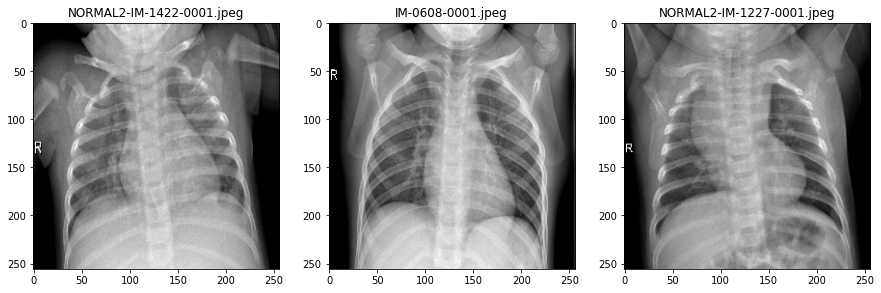

Bacterial Pneumonia Lungs:


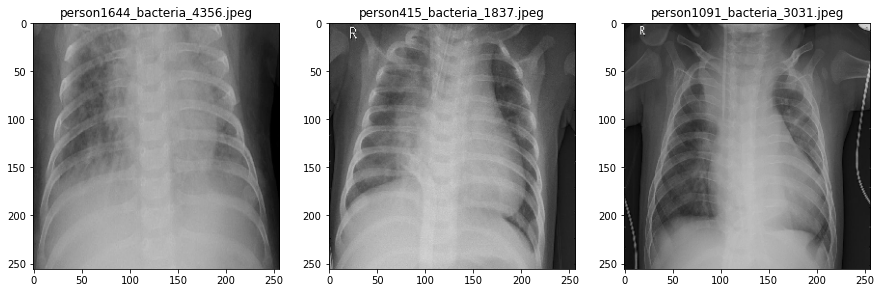

Viral Pneumonia Lungs:


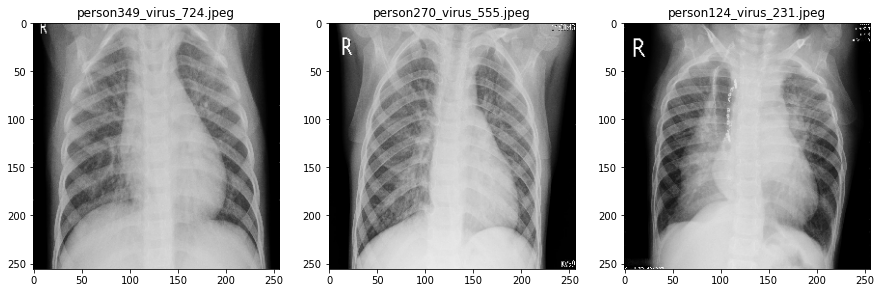

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.preprocessing.image import load_img

npix = 256
target_size = (npix,npix,1)

#fig, axs = plt.subplots(1,3)
plt.figure(figsize = (15,10))

#show three random normal lung scans

print("Normal Lungs:")
for i in range(1,4):
  random_num = np.random.randint(0, len(train_normal_images_list))
  filename = 'chest_xray/train/NORMAL/' + train_normal_images_list[random_num]
  image_load = load_img(filename, target_size=target_size)
  plt.subplot(1,3,i)
  plt.imshow(image_load)
  plt.title(train_normal_images_list[random_num])

plt.show()

#show three random bacterial pneumonia lung scans
print("Bacterial Pneumonia Lungs:")
plt.figure(figsize = (15,10))
for i in range(1,4):
  random_num = np.random.randint(0, len(train_pneumonia_images_list_subset_bacteria))
  filename = 'chest_xray/train/PNEUMONIA/' + train_pneumonia_images_list_subset_bacteria[random_num]
  image_load = load_img(filename, target_size=target_size)
  plt.subplot(1,3,i)
  plt.imshow(image_load)
  plt.title(train_pneumonia_images_list_subset_bacteria[random_num])

plt.show()


#show three random viral pneumonia lung scans
print("Viral Pneumonia Lungs:")
plt.figure(figsize = (15,10))
for i in range(1,4):
  random_num = np.random.randint(0, len(train_pneumonia_images_list_subset_virus))
  filename = 'chest_xray/train/PNEUMONIA/' + train_pneumonia_images_list_subset_virus[random_num]
  image_load = load_img(filename, target_size=target_size)
  plt.subplot(1,3,i)
  plt.imshow(image_load)
  plt.title(train_pneumonia_images_list_subset_virus[random_num])

plt.show()

plt.tight_layout()
pass

At first glance from this small sample of x-ray images, it is not so simple to diagnose whether a lung is infected with pneumonia or is healthy. We found it personally difficult to differentiate between normal lungs and lungs with viral pneumonia.

### Load images into numpy arrays


Now that we've taken a look at what these images look like, it is time to convert the dataset into a format that is compatible with Neural Networks. We use the OpenCV library to read and convert all the images into NumPy arrays. For our baseline, we will resize each image to a 150x150 array.

In [ ]:
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)   #normal is 0, pneumonia is 1
        for img in os.listdir(path):      
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)   #read in image file
                resized_arr = cv2.resize(img_arr, (img_size, img_size))               #resize the image to 150x150 array
                
                data.append([resized_arr, class_num])  #labels all images in folder Normal as 0, all images in folder pneumonia as 1
            except Exception as e:
                print(e)
    
    return np.array(data)

In [ ]:
#original load from the kaggle set, but it has suspect validation set with 16 images (takes about 49 seconds to execute)

raw_train = get_training_data('chest_xray/train')  #(5216, 2)
raw_test = get_training_data('chest_xray/test')    #(624, 2)
raw_val = get_training_data('chest_xray/val')      #(16, 2)

print("Raw set sizes:")
print("Train:", np.shape(raw_train))
print("Test:", np.shape(raw_test))
print("Val:", np.shape(raw_val))



Raw set sizes:
Train: (5216, 2)
Test: (624, 2)
Val: (16, 2)


We noticed that the prescribed validation set in the Kaggle dataset has only 16 images. This is extremely small so we will combine all the images and re-apportion them into more appropriate sizes for train, test, and validation sets.

### Create train-test-validation sets

Approximately 80-10-10 split after combining and shuffling the training and validation sets. We will keep the testing set as-is.

In [ ]:
full_train_dataset = np.concatenate((raw_train, raw_val))
print(np.shape(full_train_dataset))

(5232, 2)


In [ ]:
np.random.seed(6)
shuffle = np.random.permutation(np.arange(full_train_dataset.shape[0]))
full_train_dataset = full_train_dataset[shuffle]

In [ ]:
#80-10-10 split
train = full_train_dataset[:4608]
val = full_train_dataset[4608:5232]
test = raw_test

print(np.shape(train))
print(np.shape(test))
print(np.shape(val))

(4608, 2)
(624, 2)
(624, 2)


In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))
print(np.shape(x_val), np.shape(y_val))

(4608, 150, 150) (4608,)
(624, 150, 150) (624,)
(624, 150, 150) (624,)


### Exploratory Analysis

Let's check for balance between labels: Normal and Pneumonia in our new train, test, and validation sets.

Counter({1: 3424, 0: 1184})
Counter({1: 390, 0: 234})
Counter({1: 459, 0: 165})


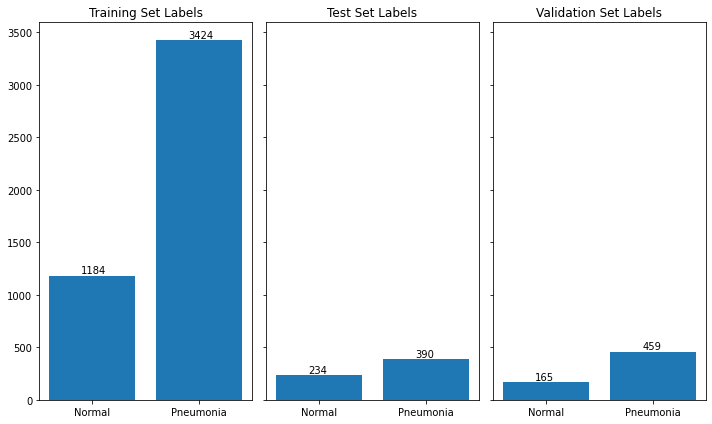

In [ ]:
#check for balance among labels for the train, test, and val sets

from collections import Counter

print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))

fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey = True, figsize = (10,6))


w = Counter(y_train)
w = dict(sorted(w.items()))
train_bars = ax1.bar(w.keys(), w.values(), tick_label = ['Normal', 'Pneumonia'])
ax1.title.set_text('Training Set Labels')
for bar in train_bars:
    yval = bar.get_height()
    xval = bar.get_x()
    ax1.text(xval+0.3, yval+20, yval)

x = Counter(y_test)
x = dict(sorted(x.items()))
test_bars = ax2.bar(x.keys(), x.values(), tick_label = ['Normal', 'Pneumonia'])
ax2.title.set_text('Test Set Labels')
for bar in test_bars:
    yval = bar.get_height()
    xval = bar.get_x()
    ax2.text(xval+0.3, yval+20, yval)

y = Counter(y_val)
y = dict(sorted(y.items()))
val_bars = ax3.bar(y.keys(), y.values(), tick_label = ['Normal', 'Pneumonia'])
ax3.title.set_text('Validation Set Labels')
for bar in val_bars:
    yval = bar.get_height()
    xval = bar.get_x()
    ax3.text(xval+0.3, yval+20, yval)

plt.tight_layout()

There are 1583 "Normal" images and 4273 "Pneumonia" images in the dataset. The split between the two classes is consistent across train, test, and validation sets.

### Prepare data for CNN

In [ ]:
#normalize data by dividing color values by 255 to make them from 0 to 1
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255


# resize data so we can feed into CNN
x_train = x_train.reshape(-1, img_size, img_size, 1)    #reshape(-1,) -> new shape should contain same # of elements as original
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))
print(np.shape(x_val), np.shape(y_val))

(4608, 150, 150, 1) (4608,)
(624, 150, 150, 1) (624,)
(624, 150, 150, 1) (624,)



4000 images is not a lot to train on. So in order to make the most of our relatively few training examples, we will "augment" them using a number of 
random transformations, so that our model would never see twice the exact same picture. Image augmentation also helps prevent overfitting and allows the neural network to generalize better to new unseen data.

In Keras, the ImageDataGenerator class allows us to configure random transformations and normalization operations to be done on the image data during training. In combination with the .flow() command, we will generate batches of these randomly transformed images into our neural network during training. 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

### Set up CNN Architecture

Now we can start to build a neural network architecture. Convolutional neural networks are one of the best models available for image classification. We build a stack of 3 convolution layers with ReLU activation followed by max-pooling layers. Then, we build two fully-connected "dense" layers and end the model with a single unit of output with a sigmoid activation, which is convention for binary classification.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [ ]:
"""
basic CNN implementation for images from keras documentation
"""

cnn = Sequential()
cnn.add(Conv2D(32, (3,3), activation = "relu", input_shape = (150,150,1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(32, (3,3), activation = "relu"))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(64, (3,3), activation = "relu"))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(activation = "relu", units = 64))
#cnn.add(Dropout(0.5))
cnn.add(Dense(activation = "sigmoid", units = 1))

cnn.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['accuracy'])
cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 18496)            

#### CNN Training

In [ ]:
"""
https://stackoverflow.com/questions/57092637/how-to-fit-keras-imagedatagenerator-for-large-data-sets-using-batches
"""

cnn_model = cnn.fit(datagen.flow(x_train, y_train, batch_size=32), epochs = 50, validation_data = datagen.flow(x_val, y_val))

Epoch 1/50
144/144 [==============================] - 9s 60ms/step - loss: 0.4488 - accuracy: 0.7988 - val_loss: 0.4032 - val_accuracy: 0.7997
Epoch 2/50
144/144 [==============================] - 8s 58ms/step - loss: 0.3171 - accuracy: 0.8579 - val_loss: 0.2625 - val_accuracy: 0.8846
Epoch 3/50
144/144 [==============================] - 9s 59ms/step - loss: 0.2629 - accuracy: 0.8906 - val_loss: 0.2184 - val_accuracy: 0.9199
Epoch 4/50
144/144 [==============================] - 8s 58ms/step - loss: 0.2434 - accuracy: 0.8991 - val_loss: 0.2358 - val_accuracy: 0.9022
Epoch 5/50
144/144 [==============================] - 8s 59ms/step - loss: 0.2203 - accuracy: 0.9097 - val_loss: 0.1769 - val_accuracy: 0.9359
Epoch 6/50
144/144 [==============================] - 9s 60ms/step - loss: 0.2123 - accuracy: 0.9080 - val_loss: 0.1654 - val_accuracy: 0.9471
Epoch 7/50
144/144 [==============================] - 8s 59ms/step - loss: 0.1984 - accuracy: 0.9225 - val_loss: 0.1782 - val_accuracy: 0.9391

#### Test Accuracy

In [ ]:
print("Loss of CNN model is - " , cnn.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , cnn.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 5ms/step - loss: 0.3109 - accuracy: 0.9071
Loss of CNN model is -  0.3108675181865692
20/20 [==============================] - 0s 5ms/step - loss: 0.3109 - accuracy: 0.9071
Accuracy of CNN model is -  90.70512652397156 %


In [ ]:
#model_predictions = cnn.predict_classes(x_test)
model_predictions = (cnn.predict(x_test) > 0.5).astype("int32")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9356    0.8077    0.8670       234
           1     0.8934    0.9667    0.9286       390

    accuracy                         0.9071       624
   macro avg     0.9145    0.8872    0.8978       624
weighted avg     0.9092    0.9071    0.9055       624



In [ ]:
confusion_matrix(y_test, model_predictions)

array([[189,  45],
       [ 13, 377]])

(2.0, 0.0)

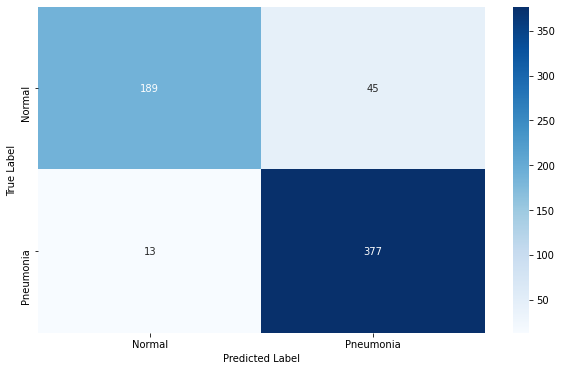

In [ ]:
import seaborn as sns

index = ['Normal', 'Pneumonia']
columns = ['Normal', 'Pneumonia']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(2, 0)

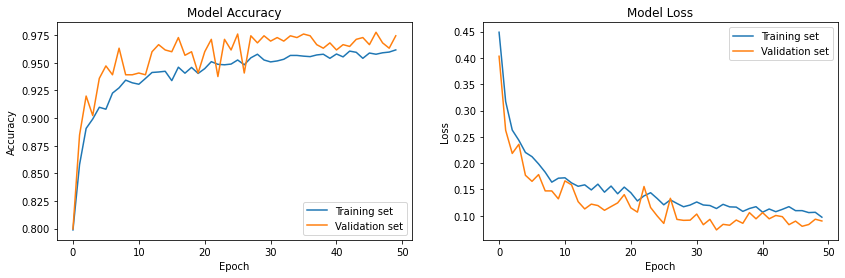

In [ ]:
# Accuracy 
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='lower right')

# Loss 

plt.subplot(1,2,2)
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')

plt.show()

We have a very strong baseline of 90.71% test accuracy.
Let's try to build upon what we have by changing our model to multi-class classification since we noticed that pneumonia can be differentiated between viral and bacterial.

# Switching to Multi-class...

We found that the multi-class classification problem to have been a lot more complicated than binary classification. We tried to improve upon our existing CNN model but quickly learned that simply adding more layers in our model did not yield great results. We also tried existing architectures like VGG16 (which won in previous ImageNet competitions) but results rarely reached above 80% test accuracy.

After reading many papers, we found some methods that were able to improve our results: [**Image Preprocessing**](https://arxiv.org/ftp/arxiv/papers/2006/2006.12229.pdf) and [**Ensemble Learning**](https://arxiv.org/pdf/2006.13817.pdf).

## Multiclass - Image Preprocessing (224x224)

### Preprocessing Demo

The diaphragm in the x-ray images are usually regions with the brightest pixels. We theorize that these high-intensity white areas may have a negative effect on distinguishing potential patterns of disease in the lung areas which would interfere with classification. Thus, the first step of the preprocessing algorithm would be to binarize the image and convert it into black and white. 

How do we determine which pixels get turned off (black/0) and which pixels get turned on (white/1)? 

$threshold = V_{min} + param * (V_{max} - V_{min})$

Any pixel value greater than the threshold would be turned on and any pixel less than the threshold would be turned off.

But how do we tune $param$? 

We implement a decrementing loop (starting at $param=0.85$) until we believe all the pixels that are turned on resemble the diaphragm. The stopping condition is based on the total area of the pixels turned on. 

Through trial and error, we believe that the diaphragm region takes up about 3-4% of the total area (or number of non-zero pixels) in the image. Thus, if a $param$ is reached such that all the pixels that are above the threshold take up no more than 4% of total pixels, then we have reached the point where the diaphragm is identified. 

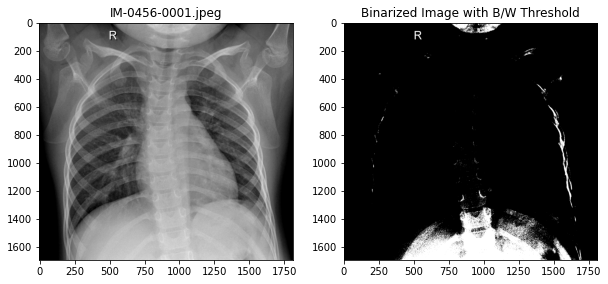

In [ ]:
random_num = np.random.randint(0, len(train_normal_images_list))
import copy

data_dir = 'chest_xray/train'
label = 'NORMAL'
path = os.path.join(data_dir, label)
img = train_normal_images_list[random_num]
filename = os.path.join(path, img)

image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_binarized = copy.deepcopy(gray)
#get binary image after threshold
gray_r = gray_binarized.reshape(gray.shape[0] * gray.shape[1])
threshold = gray_r.min() + 0.73 * (gray_r.max() - gray_r.min())

for i in range(gray_r.shape[0]):
  if gray_r[i] > threshold:
    gray_r[i] = 1
  else:
    gray_r[i] = 0

gray_2 = gray_r.reshape(gray.shape[0], gray.shape[1])

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.imshow(gray, cmap = 'gray')
plt.title(img)


plt.subplot(1,2,2)
plt.imshow(gray_2, cmap='gray')
plt.title('Binarized Image with B/W Threshold')
plt.show()

In the pictures shown here, $param$ specified is 0.73, and we can start to see the contour of the diaphragm being identified.

Next, we can use morphological filters to smooth the boundary of the diaphragm region.

10338 contours detected
(5374, 1, 2)


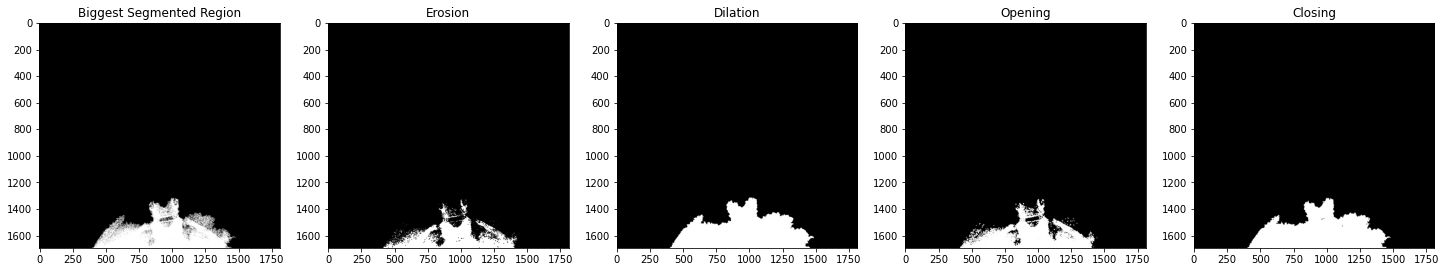

In [ ]:
#select biggest segmented region

mask = np.zeros(gray_2.shape, np.uint8)
# ret, gray3 = cv2.threshold(gray, 250, 255, 0)

contours, hier = cv2.findContours(gray_2.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#plt.imshow(contours, cmap='gray')
print(str(len(contours)) + ' contours detected')

largest_area = sorted(contours, key=cv2.contourArea)[-1]
print(np.shape(largest_area))

cv2.drawContours(mask, [largest_area], 0, (255,255,255,255), -1)
image_remainder = cv2.bitwise_and(gray_2, mask)

plt.figure(figsize=(25,40))
plt.subplot(5,5,1)
plt.imshow(image_remainder, cmap='gray')
plt.title('Biggest Segmented Region')
#plt.show()


#morphological filter...erosion..smoothing
kernel = np.ones((5,5), np.uint8)
erosion = cv2.erode(image_remainder, kernel, iterations = 1)
plt.subplot(5,5,2)
plt.imshow( erosion, cmap = 'gray')
plt.title('Erosion')
#plt.show()

#dilate....works best??
dilation = cv2.dilate(image_remainder, kernel, iterations = 1)
plt.subplot(5,5,3)
plt.imshow(dilation, cmap = 'gray')
plt.title('Dilation')
#plt.show()

#open
opening = cv2.morphologyEx(image_remainder, cv2.MORPH_OPEN, kernel)
plt.subplot(5,5,4)
plt.imshow(opening, cmap = 'gray')
plt.title('Opening')
#plt.show()

#close
closing = cv2.morphologyEx(image_remainder, cv2.MORPH_CLOSE, kernel)
plt.subplot(5,5,5)
plt.imshow(closing, cmap = 'gray')
plt.title('Closing')
plt.show()

We explore some basic types of morphological transformations that help smooth the pixels in the contour's boundaries. We will go with **Dilation** going forward.

After, we will map the processed diaphragm binary image back to the original image to effectively remove the diaphragm.

(1255, 1, 2)


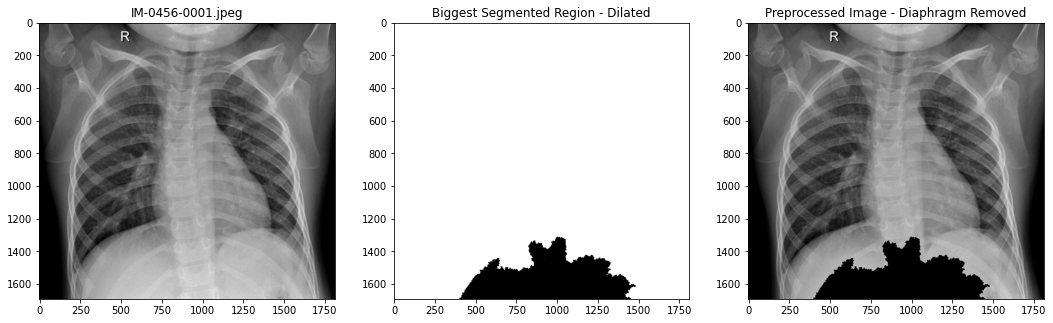

In [ ]:
#subtraction
image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_copy = copy.deepcopy(gray)
# 0 - black
# 255 - white


#https://stackoverflow.com/questions/54948816/how-to-replace-a-masked-part-of-an-image-with-another-image-using-opencv-python

contours_dilation, hier_dilation = cv2.findContours(dilation.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
largest_area_dilation = sorted(contours_dilation, key=cv2.contourArea)[-1]
print(np.shape(largest_area_dilation))

for contour in contours_dilation:
  gray_removed_diaphgram = cv2.drawContours(gray_copy, [(contour)], -1, (0,255,255), -1)

plt.figure(figsize=(18,24))
plt.subplot(3,3,1)
plt.imshow(gray, cmap = 'gray')
plt.title(img)
#plt.show()

plt.subplot(3,3,2)
plt.imshow(cv2.bitwise_not(dilation), cmap = 'gray')
plt.title('Biggest Segmented Region - Dilated')
#plt.show()

plt.subplot(3,3,3)
plt.imshow(gray_removed_diaphgram, cmap = 'gray')
plt.title('Preprocessed Image - Diaphragm Removed')
plt.show()

In the next step, we convert the current gray-scale preprocessed image (let's refer to this as $img_{pp}$) to a 3-channel (RGB) image that is suitable for training our neural network (VGG16). 

First, since the X-ray images often include additive noise, we apply a bilateral low-pass filter to $img_{pp}$. This filter is a non-linear filter and highly effective at nosie removal while preserving textural information. This preprocessed image will be referred as $img_{bf}$. 

Second, X-ray images may have different image contrast or brightness due to the difference in patient body size and/or variation of X-ray dose. To compensate this potentially negative impact, we apply a histogram equalization method to normalize $img_{pp}$ as well. This preprocessed image will be referred as $img_{he}$. ([Heidari et al](https://arxiv.org/ftp/arxiv/papers/2006/2006.12229.pdf))

Text(0.5, 1.0, 'Bilateral Filtering')

<Figure size 1080x720 with 0 Axes>

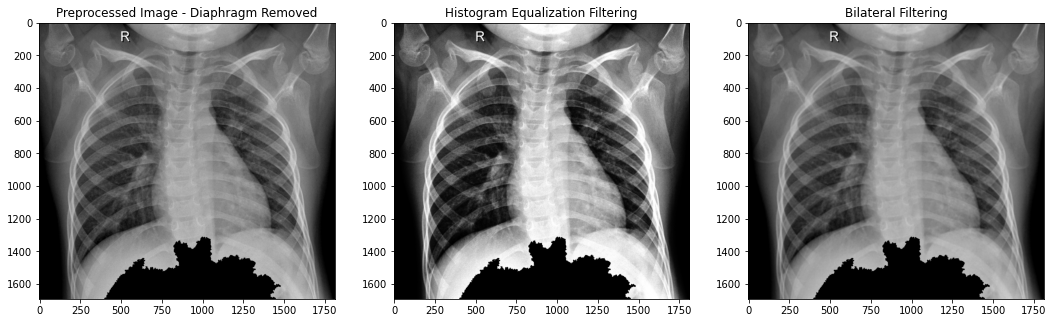

In [ ]:
plt.figure(figsize = (15,10))
gray_removed_diaphgram_equ = cv2.equalizeHist(gray_removed_diaphgram)
gray_removed_diaphgram_bifilter = cv2.bilateralFilter(gray_removed_diaphgram, 9, 75, 75)

plt.figure(figsize=(18,24))
plt.subplot(3,3,1)
plt.imshow(gray_removed_diaphgram, cmap = 'gray')
plt.title('Preprocessed Image - Diaphragm Removed')

plt.subplot(3,3,2)
plt.imshow(gray_removed_diaphgram_equ, cmap = 'gray')
plt.title('Histogram Equalization Filtering')

plt.subplot(3,3,3)
plt.imshow(gray_removed_diaphgram_bifilter, cmap = 'gray')
plt.title('Bilateral Filtering')




Together, $img_{he}$, $img_{pp}$, and $img_{bf}$ merge to become the new RGB channels respectively in our newly preprocessed image. 

(1693, 1812, 3)

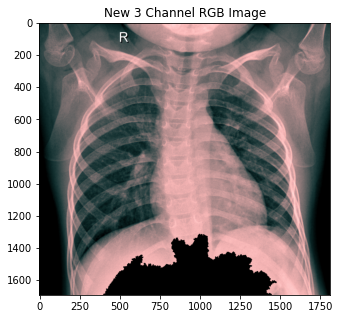

In [ ]:
new_image = cv2.merge((gray_removed_diaphgram_equ, gray_removed_diaphgram, gray_removed_diaphgram_bifilter ))
plt.figure(figsize = (7,5))
plt.imshow(new_image, cmap = 'gray')
plt.title('New 3 Channel RGB Image')
np.shape(new_image)

Performing this diaphragm removal preprocessing on the full image dataset took about two days to complete.
We've saved the results into numpy arrays for easier transport.

#### Preprocessing Algorithm

In [ ]:
#from progressbar import *
from keras.preprocessing.image import img_to_array
import copy

labels = ['NORMAL', 'PNEUMONIA']
img_size = 224  

def get_training_data_preprocessing(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)

        with tqdm(total = len(os.listdir(path))) as pbar:
          for i, img in enumerate(os.listdir(path)):  
              pbar.set_description("processing {} ".format(path))

              if "virus" in img:
                  class_num = 2
              elif "bacteria" in img:
                  class_num = 1
              else:
                  class_num = 0
              try:
                  img_arr = cv2.imread(os.path.join(path, img))   #read in image file  cv2.IMREAD_GRAYSCALE 
                  total_area = img_arr.size
                  #print("Total area:", total_area)

                  gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)

                  gray_copy = copy.deepcopy(gray)

                  #get binary image by setting a certain threshold
                  #write a while loop that'll find best threshold for each image? 
                  #set an area threshold as well?

                  gray_binarized = copy.deepcopy(gray)
                  gray_r = gray_binarized.reshape(gray_binarized.shape[0] * gray_binarized.shape[1])

                  threshold_param = 0.85

                  while threshold_param <= 0.85:
                      gray_r_copy = copy.deepcopy(gray_r)
                      #print("threshold param:", threshold_param)          
                      threshold = gray_r_copy.min() + threshold_param * (gray_r_copy.max() - gray_r_copy.min())  #default baseline 73
                      #print("calculated threshold:", threshold)
                      for j in range(gray_r_copy.shape[0]):
                          if gray_r_copy[j] > threshold:
                              gray_r_copy[j] = 1
                          else:
                              gray_r_copy[j] = 0

                      gray_binary = gray_r_copy.reshape(gray_binarized.shape[0], gray_binarized.shape[1])

                      #select biggest segmented region
                      mask = np.zeros(gray_binary.shape, np.uint8)

                      contours, hier = cv2.findContours(gray_binary.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                      largest_area = sorted(contours, key=cv2.contourArea)[-1]

                      cv2.drawContours(mask, [largest_area], 0, (255,255,255,255), -1)
                      segmented_region = cv2.bitwise_and(gray_binary, mask)

                      #print("largest area:", cv2.contourArea(largest_area))
                      
                      if cv2.contourArea(largest_area)/total_area > 0.04:  #diaphragm is approx 3% of total area?
                      #if cv2.contourArea(largest_area) > 130000:
  #                             threshold_param += 0.01  #oops went too far, revert back
  #                             gray_r_copy = copy.deepcopy(gray_r)
  #                             threshold = gray_r_copy.min() + threshold_param * (gray_r_copy.max() - gray_r_copy.min())
  #                             for j in range(gray_r_copy.shape[0]):
  #                                 if gray_r_copy[j] > threshold:
  #                                     gray_r_copy[j] = 1
  #                                 else:
  #                                     gray_r_copy[j] = 0
  #                             gray_binary = gray_r_copy.reshape(gray_binarized.shape[0], gray_binarized.shape[1])
  #                             mask = np.zeros(gray_binary.shape, np.uint8)
  #                             contours, hier = cv2.findContours(gray_binary.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  #                             largest_area = sorted(contours, key=cv2.contourArea)[-1]
  #                             cv2.drawContours(mask, [largest_area], 0, (255,255,255,255), -1)
  #                             segmented_region = cv2.bitwise_and(gray_binary, mask)
                          break
                      else:
                          #print("ratio of segmented to total area:", cv2.contourArea(largest_area)/total_area)
                          threshold_param -= 0.01


                  #print(cv2.contourArea(largest_area))

                  #apply morphological filtering...dilation
                  kernel = np.ones((5,5), np.uint8)
                  dilation = cv2.dilate(segmented_region, kernel, iterations = 1)

                  #subtract the dilated contour from the original image
                  contours_dilation, hier_dilation = cv2.findContours(dilation.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                  largest_area_dilation = sorted(contours_dilation, key=cv2.contourArea)[-1]

                  for contour in contours_dilation:
                      gray_removed_diaphgram = cv2.drawContours(gray_copy, [(contour)], -1, (0,255,255), -1)    #this will be the new Green channel

                  #apply histogram equalization to gray removed diaphragm
                  gray_removed_diaphgram_equ = cv2.equalizeHist(gray_removed_diaphgram)    #this will be the new Red channel

                  #apply bilateral filtering to gray removed diaphragm
                  gray_removed_diaphgram_bifilter = cv2.bilateralFilter(gray_removed_diaphgram, 15, 75, 75)   #this will be the new Blue channel


                  #output new 3 channel RGB image
                  new_img = cv2.merge((gray_removed_diaphgram_equ, gray_removed_diaphgram, gray_removed_diaphgram_bifilter ))


                  #img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
                  resized_arr = cv2.resize(new_img, (img_size, img_size))     #resize the image to 224x224 array
                  data.append([resized_arr, class_num])  #labels all images in folder Normal as 0, all images in folder pneumonia as 1

                  # img_arr = load_img(os.path.join(path, img), target_size = (img_size, img_size))
                  # img_arr = img_to_array(img_arr)
                  # img_arr = np.expand_dims(img_arr, axis=0)
                  # data.append([img_arr, class_num])


              except Exception as e:
                  print(e)
              pbar.update(1)
        #pbar.finish()
    return np.array(data)

### Setup Data Environment
We've also saved the preprocessed images and uploaded them as a Kaggle dataset.

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload() # upload kaggle.json from your account...this includes your API access key

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d juliantsang1/xray-pneumonia-preprocessing
! unzip xray-pneumonia-preprocessing.zip

! ls -l preprocessed_images

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0439-0001-0002.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0439-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0440-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0441-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0442-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0444-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0445-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0446-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0447-0001.jpeg  
  inflating: preprocessed_images/preprocessed_train_images/preprocessed_IM-0448-0001.jpeg  
  inflating: preprocesse

### Load preprocessed images into numpy arrays

In [ ]:
rgb_preprocessed_train = np.load("preprocessed_images_numpy/preprocessed_train_v2.npy", allow_pickle=True)
rgb_preprocessed_test = np.load("preprocessed_images_numpy/preprocessed_test_v2.npy", allow_pickle=True)
rgb_preprocessed_val = np.load("preprocessed_images_numpy/preprocessed_val_v2.npy", allow_pickle=True)

print(np.shape(rgb_preprocessed_train))
print(np.shape(rgb_preprocessed_test))
print(np.shape(rgb_preprocessed_val))

(5216, 2)
(624, 2)
(16, 2)


In [ ]:
train_images_list = os.listdir('preprocessed_images/preprocessed_train_images/')
np.shape(train_images_list)

train_normal_images_list = [i for i in train_images_list if 'virus' not in i and 'bacteria' not in i]
train_virus_pneumonia_images_list = [i for i in train_images_list if 'virus' in i]
train_bacteria_pneumonia_images_list = [i for i in train_images_list if 'bacteria' in i]

print(np.shape(train_normal_images_list))
print(np.shape(train_virus_pneumonia_images_list))
print(np.shape(train_bacteria_pneumonia_images_list))

(1341,)
(1345,)
(2530,)


#### Take a look at the preprocessed images

Normal Lungs:


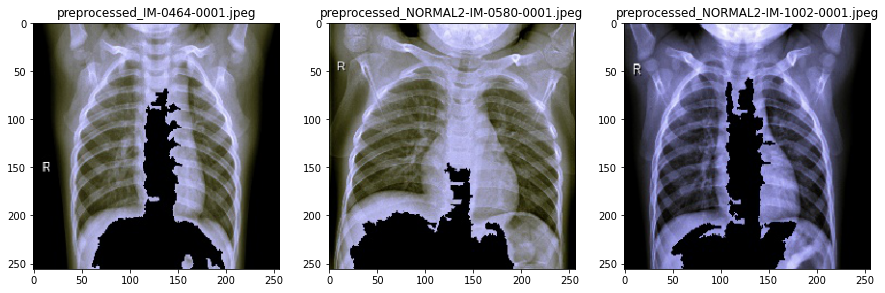

Bacterial Pneumonia Lungs:


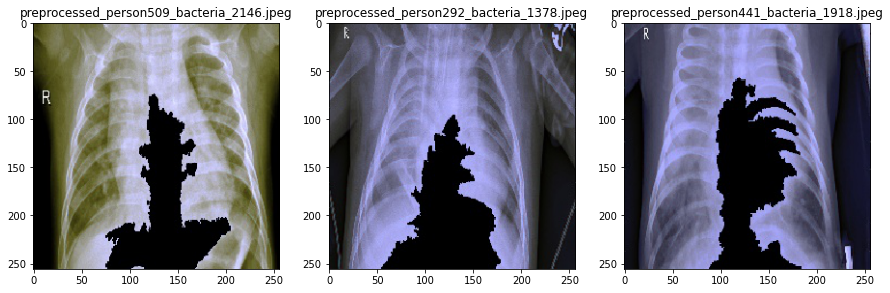

Viral Pneumonia Lungs:


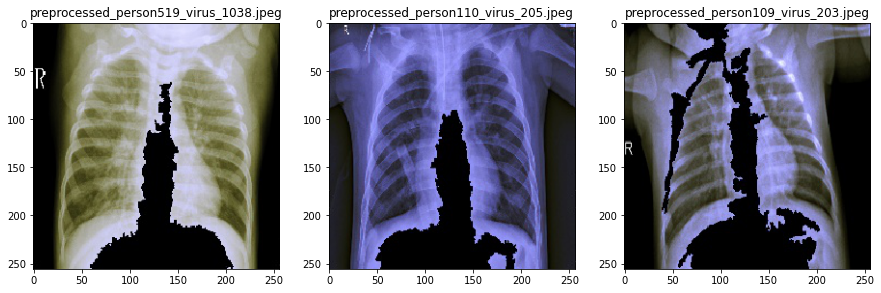

<Figure size 432x288 with 0 Axes>

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

npix = 256
target_size = (npix,npix,1)

#fig, axs = plt.subplots(1,3)


#show normal lung scan
print("Normal Lungs:")
plt.figure(figsize = (15,10))
for i in range(1,4):
  random_num = np.random.randint(0, len(train_normal_images_list))
  filename = 'preprocessed_images/preprocessed_train_images/' + train_normal_images_list[random_num]
  image_load = load_img(filename, target_size=target_size)
  plt.subplot(1,3,i)
  plt.imshow(image_load)
  plt.title(train_normal_images_list[random_num])

plt.show()

#show bacterial pneumonia lung scan
print("Bacterial Pneumonia Lungs:")
plt.figure(figsize = (15,10))
for i in range(1,4):
  random_num = np.random.randint(0, len(train_bacteria_pneumonia_images_list))
  filename = 'preprocessed_images/preprocessed_train_images/' + train_bacteria_pneumonia_images_list[random_num]
  image_load = load_img(filename, target_size=target_size)
  plt.subplot(1,3,i)
  plt.imshow(image_load)
  plt.title(train_bacteria_pneumonia_images_list[random_num])

plt.show()

#show viral pneumonia lung scan
print("Viral Pneumonia Lungs:")
plt.figure(figsize = (15,10))
for i in range(1,4):
  random_num = np.random.randint(0, len(train_virus_pneumonia_images_list))
  filename = 'preprocessed_images/preprocessed_train_images/' + train_virus_pneumonia_images_list[random_num]
  image_load = load_img(filename, target_size=target_size)
  plt.subplot(1,3,i)
  plt.imshow(image_load)
  plt.title(train_virus_pneumonia_images_list[random_num])

plt.show()


plt.tight_layout()
pass

### Create train-test-validation sets

Irrespective of the increased data points from RGB, we still keep aside all test data and then took a 90-10 split of the remaining images to be training and validation, respectively.

In [ ]:
full_train_dataset = np.concatenate((rgb_preprocessed_train, rgb_preprocessed_val)) #rgb_preprocessed_test
print(np.shape(full_train_dataset))

(5232, 2)


In [ ]:
np.random.seed(6)
shuffle = np.random.permutation(np.arange(full_train_dataset.shape[0]))
full_train_dataset = full_train_dataset[shuffle]

#toggle training/val/test sizes here
train = full_train_dataset[:4708]     #90% of full train dataset
val = full_train_dataset[4708:]   #10% of full train dataset
test = rgb_preprocessed_test      #test set as-is

print("Shuffled Train:", np.shape(train))
print("Shuffled Test:", np.shape(test))
print("Shuffled Val:", np.shape(val))

Shuffled Train: (4708, 2)
Shuffled Test: (624, 2)
Shuffled Val: (524, 2)


In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

print("Train Set Size:", np.shape(x_train), np.shape(y_train))
print("Test Set Size:", np.shape(x_test), np.shape(y_test))
print("Val Set Size:", np.shape(x_val), np.shape(y_val))

Train Set Size: (4708, 224, 224, 3) (4708,)
Test Set Size: (624, 224, 224, 3) (624,)
Val Set Size: (524, 224, 224, 3) (524,)


### Balance Checks

In [ ]:
#check for balance among labels for the train, test, and val sets

from collections import Counter

print(Counter(y_train))
print(Counter(y_test))
print(Counter(y_val))

Counter({1: 2292, 0: 1215, 2: 1201})
Counter({1: 242, 0: 234, 2: 148})
Counter({1: 246, 2: 144, 0: 134})


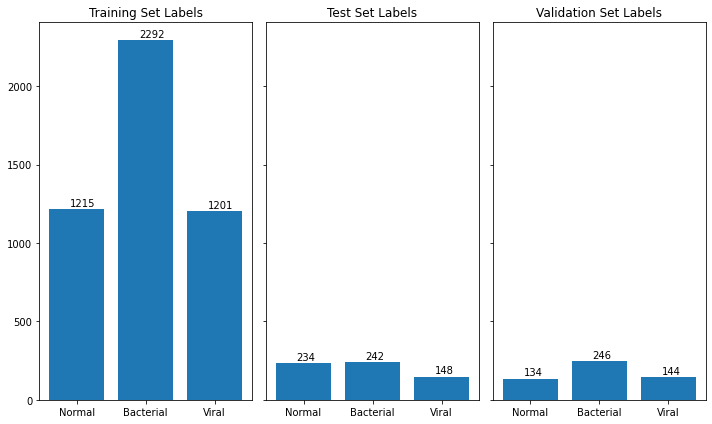

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey = True, figsize = (10,6))


w = Counter(y_train)
w = dict(sorted(w.items()))
train_bars = ax1.bar(w.keys(), w.values(), tick_label = ['Normal', 'Bacterial', 'Viral'])
ax1.title.set_text('Training Set Labels')
for bar in train_bars:
    yval = bar.get_height()
    xval = bar.get_x()
    ax1.text(xval+0.3, yval+20, yval)

x = Counter(y_test)
x = dict(sorted(x.items()))
test_bars = ax2.bar(x.keys(), x.values(), tick_label = ['Normal', 'Bacterial', 'Viral'])
ax2.title.set_text('Test Set Labels')
for bar in test_bars:
    yval = bar.get_height()
    xval = bar.get_x()
    ax2.text(xval+0.3, yval+20, yval)

y = Counter(y_val)
y = dict(sorted(y.items()))
val_bars = ax3.bar(y.keys(), y.values(), tick_label = ['Normal', 'Bacterial', 'Viral'])
ax3.title.set_text('Validation Set Labels')
for bar in val_bars:
    yval = bar.get_height()
    xval = bar.get_x()
    ax3.text(xval+0.3, yval+20, yval)

plt.tight_layout()

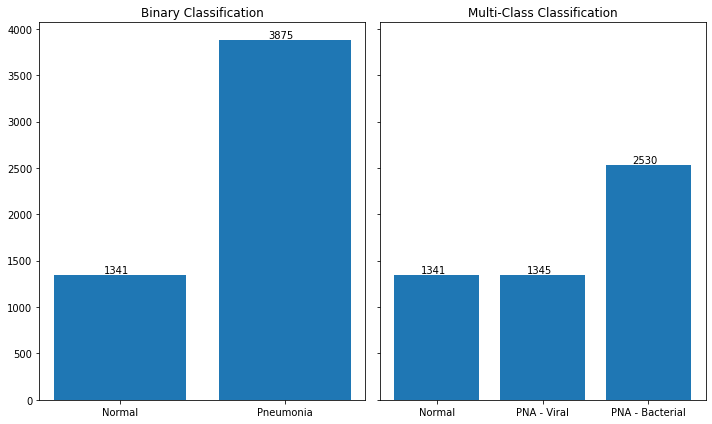

In [ ]:
"""
second plot: check for total value counts between normal and pneumonia
"""

fig, (ax1, ax2) = plt.subplots(ncols = 2, sharey = True, figsize = (10,6))


a = len(train_normal_images_list)
b = len(train_virus_pneumonia_images_list + train_bacteria_pneumonia_images_list)
counts = [a,b]
types = ['Normal', 'Pneumonia']
bars1 = ax1.bar(types, counts, tick_label = types)
ax1.title.set_text('Binary Classification')
for bar in bars1:
    yval = bar.get_height()
    xval = bar.get_x()
    ax1.text(xval+0.3, yval+20, yval)

c = len(train_virus_pneumonia_images_list)
d = len(train_bacteria_pneumonia_images_list)

types = ['Normal', 'PNA - Viral', 'PNA - Bacterial']
counts = [a,c,d]
bars2 = ax2.bar(types, counts, tick_label = types)
plt.title('Multi-Class Classification')
for bar in bars2:
    yval = bar.get_height()
    xval = bar.get_x()
    ax2.text(xval+0.25, yval+20, yval)
    
plt.tight_layout()

### Prepare data for CNN

In [ ]:
#normalize data by dividing color values by 255 to make them from 0 to 1
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

# for 3 channels
y_train = np.expand_dims(y_train, axis = 1)
y_test = np.expand_dims(y_test, axis = 1)
y_val = np.expand_dims(y_val, axis = 1)


print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))
print(np.shape(x_val), np.shape(y_val))

(4708, 224, 224, 3) (4708, 1)
(624, 224, 224, 3) (624, 1)
(524, 224, 224, 3) (524, 1)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=False,
        fill_mode='nearest')

datagen.fit(x_train)

### VGG16 Architecture

VGG16 is a commonly used architecture for image classification problems. In the competition using the ImageNet dataset with 14 million images, VGG16 scored second place on image classification in 2014. 

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers

from keras.applications.vgg16 import VGG16

from tensorflow.keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience = 5, verbose = 0, min_lr = 0.00001)

vgg16_model = VGG16(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
#vgg16_model.trainable = True
vgg16_model.trainable = False


cnn = Sequential()
cnn.add(vgg16_model)
cnn.add(Flatten())
cnn.add(Dropout(0.2))
cnn.add(Dense(activation = "relu", units = 256))
cnn.add(Dropout(0.2))
cnn.add(Dense(activation = "relu", units = 128))
cnn.add(Dropout(0.2))
cnn.add(Dense(activation = "softmax", units = 3))

opt = optimizers.Adam(lr = 0.0001)


cnn.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy']) 
cnn.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_______________________________________________________

#### CNN Training

In [ ]:
cnn_model = cnn.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs = 40, 
                    validation_data = datagen.flow(x_val, y_val),
                    callbacks=[learning_rate_reduction])


Epoch 1/40
148/148 [==============================] - 51s 348ms/step - loss: 0.8083 - sparse_categorical_accuracy: 0.6257 - val_loss: 0.6128 - val_sparse_categorical_accuracy: 0.7252
Epoch 2/40
148/148 [==============================] - 51s 342ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.7011 - val_loss: 0.5894 - val_sparse_categorical_accuracy: 0.7328
Epoch 3/40
148/148 [==============================] - 51s 344ms/step - loss: 0.6116 - sparse_categorical_accuracy: 0.7245 - val_loss: 0.5960 - val_sparse_categorical_accuracy: 0.7080
Epoch 4/40
148/148 [==============================] - 50s 340ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.7302 - val_loss: 0.6214 - val_sparse_categorical_accuracy: 0.7061
Epoch 5/40
148/148 [==============================] - 51s 342ms/step - loss: 0.5835 - sparse_categorical_accuracy: 0.7398 - val_loss: 0.5677 - val_sparse_categorical_accuracy: 0.7576
Epoch 6/40
148/148 [==============================] - 50s 340ms/step - loss: 0.5694 -

#### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)  #reduce dimensions on y labels to make it compatible for direct comparisons

print("Loss of CNN model is - " , cnn.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , cnn.evaluate(x_test,y_test)[1]*100 , "%")


20/20 [==============================] - 2s 78ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.8478
Loss of CNN model is -  0.48189079761505127
20/20 [==============================] - 1s 59ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.8478
Accuracy of CNN model is -  84.77563858032227 %


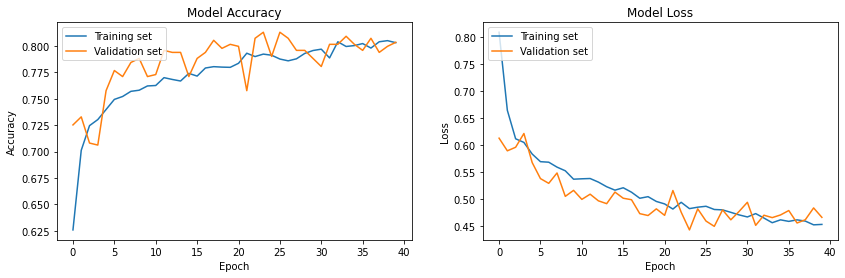

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(cnn_model.history['sparse_categorical_accuracy'])
plt.plot(cnn_model.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

#### Model Predictions

In [ ]:
model_predictions = np.argmax(cnn.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits = 4))

              precision    recall  f1-score   support

           0     0.9356    0.8077    0.8670       234
           1     0.8256    0.9587    0.8872       242
           2     0.7660    0.7297    0.7474       148

    accuracy                         0.8478       624
   macro avg     0.8424    0.8320    0.8339       624
weighted avg     0.8527    0.8478    0.8465       624



(3.0, 0.0)

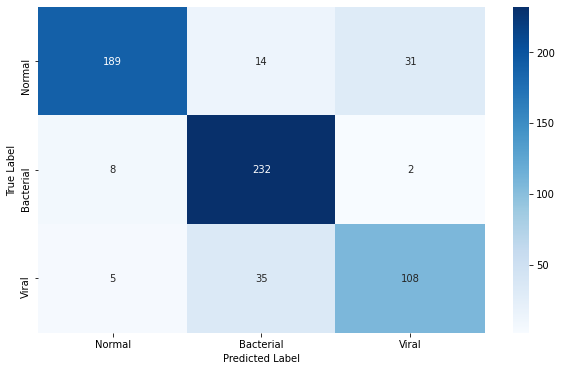

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

### DenseNet201 Architecture

In this [paper](https://arxiv.org/ftp/arxiv/papers/2004/2004.06578.pdf) by Rahman et al., DenseNet201 achieved classification accuracy, precision, and recall of normal, bacterial, and viral pneumonia of 93.3%, 93.7% and 93.2% respectively. They were able to achieve this with 5-Fold Cross Validation. We were not able to achieve level of accuracy with our dataset due to computational constraints that prevented us from implementing k-fold cross validation. However, we will try to see how well this architecture performs with our training dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20,  #try 45
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode='nearest')

datagen.fit(x_train)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience = 5, verbose = 0, min_lr = 0.00001)

"""
densenet201
"""
DenseNet_model = DenseNet201(input_shape = (224,224,3), include_top = False, weights = "imagenet")  #83.28% accuracy, 98 incorrect preds, after 40 epochs with Adam without freezing layers
DenseNet_model.trainable = False                                                                    #83.62% accuracy, 96 incorrect preds, after 50 epochs with Adam and freezing layers

cnn = Sequential()
cnn.add(DenseNet_model)
cnn.add(GlobalAveragePooling2D())
cnn.add(Dropout(0.3))
cnn.add(Dense(1024, activation = "relu"))
cnn.add(Dense(32, activation = "relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Dense(activation = "softmax", units = 3))

# #
# for layer in cnn.layers[:-8]:
#     layer.trainable=False
    
# for layer in cnn.layers[-8:]:
#     layer.trainable=True
# #

cnn.compile(optimizer = 'Adam', loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])
cnn.summary()

74842112/74836368 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              1967104   
_________________________________________________________________
dense_12 (Dense)             (None, 32)                32800     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_______________________________________________________

#### CNN Training

In [ ]:
cnn_model = cnn.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs = 40, 
                    validation_data = datagen.flow(x_val, y_val),
                    callbacks=[learning_rate_reduction])

Epoch 1/40
148/148 [==============================] - 54s 362ms/step - loss: 0.7859 - sparse_categorical_accuracy: 0.6748 - val_loss: 0.6832 - val_sparse_categorical_accuracy: 0.7176
Epoch 2/40
148/148 [==============================] - 50s 337ms/step - loss: 0.6496 - sparse_categorical_accuracy: 0.7298 - val_loss: 0.5940 - val_sparse_categorical_accuracy: 0.7538
Epoch 3/40
148/148 [==============================] - 50s 337ms/step - loss: 0.6130 - sparse_categorical_accuracy: 0.7396 - val_loss: 0.5426 - val_sparse_categorical_accuracy: 0.7538
Epoch 4/40
148/148 [==============================] - 50s 339ms/step - loss: 0.6075 - sparse_categorical_accuracy: 0.7407 - val_loss: 0.5265 - val_sparse_categorical_accuracy: 0.7748
Epoch 5/40
148/148 [==============================] - 50s 337ms/step - loss: 0.5950 - sparse_categorical_accuracy: 0.7523 - val_loss: 0.5057 - val_sparse_categorical_accuracy: 0.7901
Epoch 6/40
148/148 [==============================] - 50s 338ms/step - loss: 0.5821 -

#### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , cnn.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , cnn.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 115ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7708
Loss of CNN model is -  0.5915660858154297
20/20 [==============================] - 2s 83ms/step - loss: 0.5916 - sparse_categorical_accuracy: 0.7708
Accuracy of CNN model is -  77.08333134651184 %


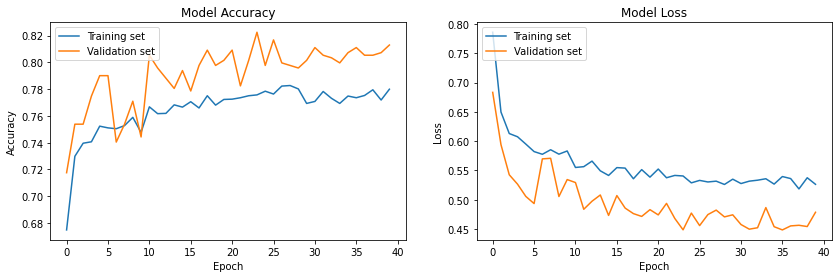

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(cnn_model.history['sparse_categorical_accuracy'])
plt.plot(cnn_model.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

#### Model Predictions

In [ ]:
model_predictions = np.argmax(cnn.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits = 4))

              precision    recall  f1-score   support

           0     0.9290    0.7265    0.8153       234
           1     0.7130    0.9752    0.8237       242
           2     0.6818    0.5068    0.5814       148

    accuracy                         0.7708       624
   macro avg     0.7746    0.7362    0.7402       624
weighted avg     0.7866    0.7708    0.7631       624



(3.0, 0.0)

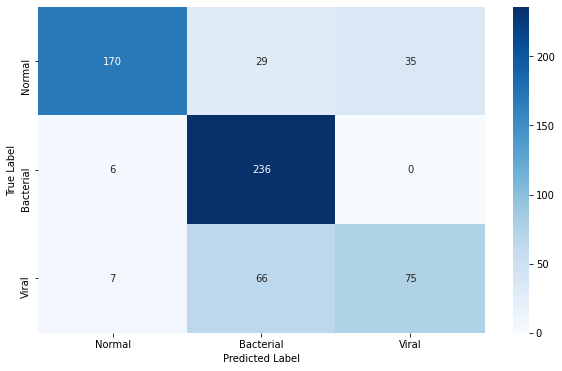

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

# Ensemble Learning

The paper by [Gour and Jain](https://arxiv.org/pdf/2006.13817.pdf) suggested using Stacked Convolutional Neural Network for diagnosing diseases in X-ray images. The idea behind this is that we would train several individual models trained on random train/test splits. Each individual model would output a prediction on the test data. However, as a collective ensemble of models, we would use those individual predictions from each model to output one final prediction. Ensembles have an overall tendency to decrease variance (decrease overfitting of the individual models) and boost performance. According to [Sollich and Krogh](https://papers.nips.cc/paper/1995/file/1019c8091693ef5c5f55970346633f92-Paper.pdf), "for learning in large ensembles, it is advantageous to use under-regularized students, which actually over-fit the training data." Thus, in training our models, we will intentionally cause them to overfit on the training data.



### Load preprocessed images into numpy arrays

In [ ]:
rgb_preprocessed_train = np.load("preprocessed_images_numpy/preprocessed_train_v2.npy", allow_pickle=True)
rgb_preprocessed_test = np.load("preprocessed_images_numpy/preprocessed_test_v2.npy", allow_pickle=True)
rgb_preprocessed_val = np.load("preprocessed_images_numpy/preprocessed_val_v2.npy", allow_pickle=True)

print(np.shape(rgb_preprocessed_train))
print(np.shape(rgb_preprocessed_test))
print(np.shape(rgb_preprocessed_val))

(5216, 2)
(624, 2)
(16, 2)


### Create train-test-validation sets


In [ ]:
full_train_dataset = np.concatenate((rgb_preprocessed_train, rgb_preprocessed_val)) 
print(np.shape(full_train_dataset))

(5232, 2)


In [ ]:
def generate_random_dataset(dataset, test_dataset):
  np.random.seed(6)
  shuffle = np.random.permutation(np.arange(dataset.shape[0]))
  full_dataset = dataset[shuffle]

  train = full_dataset[:4708]    ## 90% of full train dataset
  val = full_dataset[4708:]      ## 10% of full train dataset
  test = test_dataset     ## test set as-is

  x_train = []
  y_train = []

  x_test = []
  y_test = []

  x_val = []
  y_val = []

  for feature, label in train:
      x_train.append(feature)
      y_train.append(label)
      
  for feature, label in test:
      x_test.append(feature)
      y_test.append(label)

  for feature, label in val:
      x_val.append(feature)
      y_val.append(label)

  #normalize data by dividing color values by 255 to make them from 0 to 1
  x_train = np.array(x_train)/255
  x_val = np.array(x_val)/255
  x_test = np.array(x_test)/255

  # for 3 channels
  y_train = np.expand_dims(y_train, axis = 1)
  y_test = np.expand_dims(y_test, axis = 1)
  y_val = np.expand_dims(y_val, axis = 1)

  print("Training Set Size:", np.shape(x_train),"    Training Label Size:", np.shape(y_train))
  print("Testing Set Size:", np.shape(x_test),"    Testing Label Size:", np.shape(y_test))
  print("Validation Set Size:", np.shape(x_val),"    Validation Label Size:", np.shape(y_val))

  return x_train, x_val, x_test, y_train, y_val, y_test


In [ ]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_random_dataset(full_train_dataset, rgb_preprocessed_test)

Training Set Size: (4708, 224, 224, 3)     Training Label Size: (4708, 1)
Testing Set Size: (624, 224, 224, 3)     Testing Label Size: (624, 1)
Validation Set Size: (524, 224, 224, 3)     Validation Label Size: (524, 1)


### Balance Checks

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print("Training Labels:\n", np.asarray((unique, counts)).T)
print()
unique, counts = np.unique(y_val, return_counts=True)
print("Validation Labels:\n", np.asarray((unique, counts)).T)
print()
unique, counts = np.unique(y_test, return_counts=True)
print("Test Labels:\n", np.asarray((unique, counts)).T)

Training Labels:
 [[   0 1215]
 [   1 2292]
 [   2 1201]]

Validation Labels:
 [[  0 134]
 [  1 246]
 [  2 144]]

Test Labels:
 [[  0 234]
 [  1 242]
 [  2 148]]


### Set up CNN Architectures

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras import optimizers
from keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

def create_vgg16(optimizer, lr = 0.0001, momentum = 0.5, trainable = True):
  vgg16_model = VGG16(input_shape=(224, 224, 3),include_top=False, weights='imagenet')
  vgg16_model.trainable = trainable

  cnn = Sequential()
  cnn.add(vgg16_model)
  cnn.add(Flatten())
  cnn.add(Dropout(0.2))
  cnn.add(Dense(activation = "relu", units = 256))
  cnn.add(Dropout(0.2))
  cnn.add(Dense(activation = "relu", units = 128))
  cnn.add(Dropout(0.2))
  cnn.add(Dense(activation = "softmax", units = 3))

  if optimizer == "Adam":                          #tends to overfit
    opt = optimizers.Adam(lr = lr)
  if optimizer == "SGD":                                           #tends to stabilize
    opt = optimizers.SGD(lr = lr, momentum = momentum)

  cnn.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])  

  return cnn

def create_densenet(optimizer, lr = 0.0001, momentum = 0.5, trainable = True):
  DenseNet_model = DenseNet201(input_shape = (224,224,3), include_top = False, weights = "imagenet")  
  DenseNet_model.trainable = trainable

  cnn = Sequential()
  cnn.add(DenseNet_model)
  cnn.add(GlobalAveragePooling2D())
  cnn.add(Flatten())
  cnn.add(Dense(1000, activation = "relu"))
  cnn.add(Dense(activation = "softmax", units = 3))

  if optimizer == "Adam":
    opt = optimizers.Adam(lr = lr)
  if optimizer == "SGD":
    opt = optimizers.SGD(lr = lr, momentum = momentum)           #lr = 0.0001, momentum = 0.5 stabilizes

  cnn.compile(optimizer = opt, loss = "sparse_categorical_crossentropy", metrics = ['sparse_categorical_accuracy'])

  return cnn

### CNN Training


##### Separate Training due to RAM constraints

In [ ]:
"""
https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau

"""
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
# from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

# anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
# checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# # datagen = ImageDataGenerator(zoom_range = 0.1, horizontal_flip=True, shear_range=0.2)

# datagen = ImageDataGenerator(
#         rotation_range=310,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=False,
#         fill_mode='nearest')

# datagen.fit(x_train)
# # Fits-the-model
# # history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=128),
# history = cnn.fit(datagen.flow(x_train, y_train, batch_size=32),
#                steps_per_epoch=x_train.shape[0] //32,
#                epochs=20,
#                verbose=1,
#                callbacks=[anne, checkpoint],
#                validation_data=(x_train, y_train))

In [ ]:
# from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience = 5, verbose = 0, min_lr = 0.00001)
# # checkpoint_filepath = "/content/gdrive/My Drive/Colab Notebooks/chest x-ray/saved weights/model checkpoints"
# # model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only = False, verbose = 0, save_best_only = True)

# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=False,
#         fill_mode='nearest')

# datagen.fit(x_train)

# #before we train each model, we train/test split

# x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
# mod1_DenseNet = create_densenet()
# mod1_DenseNet_history = mod1_DenseNet.fit(datagen.flow(x_training, y_training, batch_size=16), \
#                                           epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
#                                           validation_data = datagen.flow(x_validation, y_validation), \
#                                           callbacks=[learning_rate_reduction])

# x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
# mod2_DenseNet = create_densenet()
# mod2_DenseNet_history = mod2_DenseNet.fit(datagen.flow(x_training, y_training, batch_size=16), \
#                                           epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
#                                           validation_data = datagen.flow(x_validation, y_validation), \
#                                           callbacks = [learning_rate_reduction])

# x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
# mod3_vgg16 = create_vgg16()
# mod3_vgg16_history = mod3_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
#                                     epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
#                                     validation_data = datagen.flow(x_validation, y_validation), \
#                                     callbacks = [learning_rate_reduction])

# x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
# mod4_vgg16 = create_vgg16()
# mod4_vgg16_history = mod4_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
#                                     epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
#                                     validation_data = datagen.flow(x_validation, y_validation), \
#                                     callbacks = [learning_rate_reduction])

# x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
# mod5_vgg16 = create_vgg16()
# mod5_vgg16_history = mod5_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
#                                     epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
#                                     validation_data = datagen.flow(x_validation, y_validation), \
#                                     callbacks = [learning_rate_reduction])

#### Data Generator

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', factor=0.5, patience = 5, verbose = 0, min_lr = 0.00001)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

datagen.fit(x_train)

#### Training 2 DenseNet201 Networks

Noting the relatively poor performance on the DenseNet architecture, we decided to purposely overfit on the training data. We tuned some hyper-parameters that caused overfitting such as using the Stochastic Gradient Descent, and specifying a learning rate and momentum parameters.

##### Training First Network

In [ ]:
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
mod2_DenseNet = create_densenet("SGD", lr = 0.0003, momentum = 0.9, trainable = True)
mod2_DenseNet_history = mod2_DenseNet.fit(datagen.flow(x_training, y_training, batch_size=16), \
                                          epochs = 30, steps_per_epoch = x_training.shape[0]//16, \
                                          validation_data = datagen.flow(x_validation, y_validation), \
                                          callbacks = [learning_rate_reduction])


Epoch 1/30
235/235 [==============================] - 54s 231ms/step - loss: 0.7003 - sparse_categorical_accuracy: 0.6976 - val_loss: 0.7301 - val_sparse_categorical_accuracy: 0.6720
Epoch 2/30
235/235 [==============================] - 50s 215ms/step - loss: 0.5451 - sparse_categorical_accuracy: 0.7731 - val_loss: 0.4876 - val_sparse_categorical_accuracy: 0.7887
Epoch 3/30
235/235 [==============================] - 51s 215ms/step - loss: 0.5080 - sparse_categorical_accuracy: 0.7829 - val_loss: 0.4698 - val_sparse_categorical_accuracy: 0.7919
Epoch 4/30
235/235 [==============================] - 51s 215ms/step - loss: 0.4744 - sparse_categorical_accuracy: 0.7968 - val_loss: 0.4540 - val_sparse_categorical_accuracy: 0.8057
Epoch 5/30
235/235 [==============================] - 51s 215ms/step - loss: 0.4406 - sparse_categorical_accuracy: 0.8091 - val_loss: 0.4786 - val_sparse_categorical_accuracy: 0.8153
Epoch 6/30
235/235 [==============================] - 51s 215ms/step - loss: 0.4300 -

###### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , mod2_DenseNet.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , mod2_DenseNet.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 82ms/step - loss: 0.5364 - sparse_categorical_accuracy: 0.8253
Loss of CNN model is -  0.5363591909408569
20/20 [==============================] - 2s 82ms/step - loss: 0.5364 - sparse_categorical_accuracy: 0.8253
Accuracy of CNN model is -  82.53205418586731 %


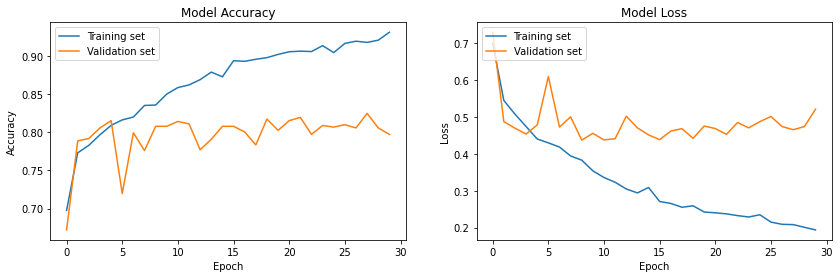

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(mod2_DenseNet_history.history['sparse_categorical_accuracy'])
plt.plot(mod2_DenseNet_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(mod2_DenseNet_history.history['loss'])
plt.plot(mod2_DenseNet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

###### Model Predictions

In [ ]:
model_predictions = np.argmax(mod2_DenseNet.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9837    0.7735    0.8660       234
           1     0.8007    0.9463    0.8674       242
           2     0.6818    0.7095    0.6954       148

    accuracy                         0.8253       624
   macro avg     0.8221    0.8097    0.8096       624
weighted avg     0.8411    0.8253    0.8261       624



(3.0, 0.0)

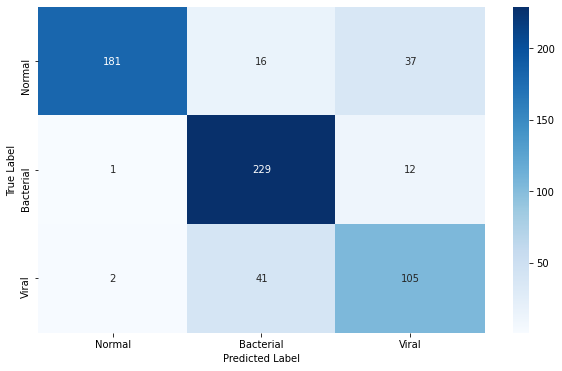

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

##### Training Second Network

In [ ]:
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
mod3_DenseNet = create_densenet("SGD", lr = 0.0003, momentum = 0.9, trainable = True)
mod3_DenseNet_history = mod3_DenseNet.fit(datagen.flow(x_training, y_training, batch_size=16), \
                                          epochs = 30, steps_per_epoch = x_training.shape[0]//16, \
                                          validation_data = datagen.flow(x_validation, y_validation), \
                                          callbacks = [learning_rate_reduction])


Epoch 1/30
235/235 [==============================] - 54s 229ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.7061 - val_loss: 0.5926 - val_sparse_categorical_accuracy: 0.7527
Epoch 2/30
235/235 [==============================] - 50s 215ms/step - loss: 0.5409 - sparse_categorical_accuracy: 0.7723 - val_loss: 0.5050 - val_sparse_categorical_accuracy: 0.7856
Epoch 3/30
235/235 [==============================] - 51s 216ms/step - loss: 0.4947 - sparse_categorical_accuracy: 0.7888 - val_loss: 0.4859 - val_sparse_categorical_accuracy: 0.7887
Epoch 4/30
235/235 [==============================] - 51s 215ms/step - loss: 0.4668 - sparse_categorical_accuracy: 0.8029 - val_loss: 0.4873 - val_sparse_categorical_accuracy: 0.7749
Epoch 5/30
235/235 [==============================] - 51s 216ms/step - loss: 0.4302 - sparse_categorical_accuracy: 0.8139 - val_loss: 0.4585 - val_sparse_categorical_accuracy: 0.7930
Epoch 6/30
235/235 [==============================] - 51s 216ms/step - loss: 0.4302 -

###### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , mod3_DenseNet.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , mod3_DenseNet.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 2s 82ms/step - loss: 0.4880 - sparse_categorical_accuracy: 0.8526
Loss of CNN model is -  0.48795586824417114
20/20 [==============================] - 2s 83ms/step - loss: 0.4880 - sparse_categorical_accuracy: 0.8526
Accuracy of CNN model is -  85.25640964508057 %


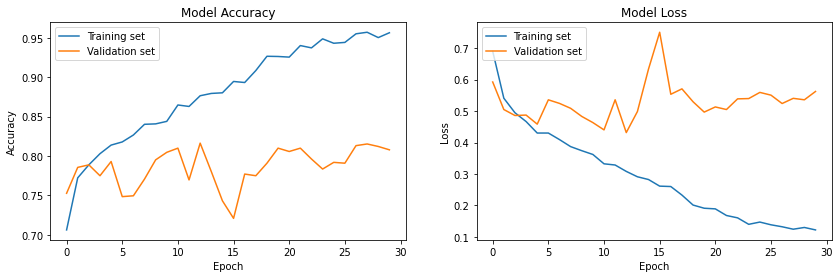

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(mod3_DenseNet_history.history['sparse_categorical_accuracy'])
plt.plot(mod3_DenseNet_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(mod3_DenseNet_history.history['loss'])
plt.plot(mod3_DenseNet_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

###### Model Predictions

In [ ]:
model_predictions = np.argmax(mod3_DenseNet.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9801    0.8419    0.9057       234
           1     0.8099    0.9504    0.8745       242
           2     0.7554    0.7095    0.7317       148

    accuracy                         0.8526       624
   macro avg     0.8485    0.8339    0.8373       624
weighted avg     0.8608    0.8526    0.8524       624



(3.0, 0.0)

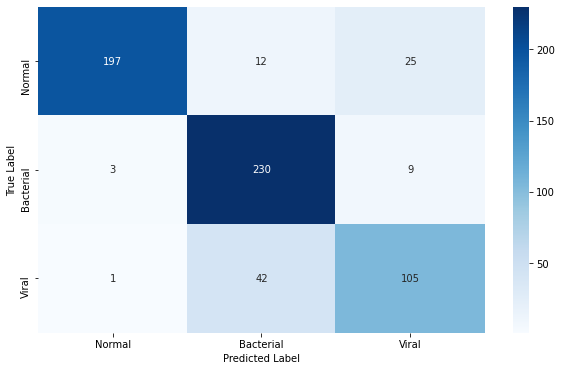

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

#### Training 4 VGG16 Networks

We will purposely overfit all of our VGG16 networks to take advantage of the variance decreasing benefits of ensemble learning. For our four models, we used the Stochastic Gradient Descent optimization that was able to cause our CNNs to overfit on the training data.

##### Training First Network

In [ ]:
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
mod4_vgg16 = create_vgg16("Adam", lr = 0.0001, trainable = True)
mod4_vgg16_history = mod4_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
                                    epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
                                    validation_data = datagen.flow(x_validation, y_validation), \
                                    callbacks = [learning_rate_reduction])




Epoch 1/40
235/235 [==============================] - 46s 196ms/step - loss: 1.0654 - sparse_categorical_accuracy: 0.4757 - val_loss: 1.0485 - val_sparse_categorical_accuracy: 0.5011
Epoch 2/40
235/235 [==============================] - 45s 194ms/step - loss: 0.8547 - sparse_categorical_accuracy: 0.5923 - val_loss: 0.6943 - val_sparse_categorical_accuracy: 0.6868
Epoch 3/40
235/235 [==============================] - 46s 194ms/step - loss: 0.7411 - sparse_categorical_accuracy: 0.6584 - val_loss: 0.6444 - val_sparse_categorical_accuracy: 0.7123
Epoch 4/40
235/235 [==============================] - 46s 195ms/step - loss: 0.6902 - sparse_categorical_accuracy: 0.6853 - val_loss: 0.7063 - val_sparse_categorical_accuracy: 0.7038
Epoch 5/40
235/235 [==============================] - 46s 195ms/step - loss: 0.6581 - sparse_categorical_accuracy: 0.7125 - val_loss: 0.6431 - val_sparse_categorical_accuracy: 0.7495
Epoch 6/40
235/235 [==============================] - 45s 194ms/step - loss: 0.6257 -

###### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , mod4_vgg16.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , mod4_vgg16.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 60ms/step - loss: 0.5191 - sparse_categorical_accuracy: 0.8478
Loss of CNN model is -  0.5190994143486023
20/20 [==============================] - 1s 59ms/step - loss: 0.5191 - sparse_categorical_accuracy: 0.8478
Accuracy of CNN model is -  84.77563858032227 %


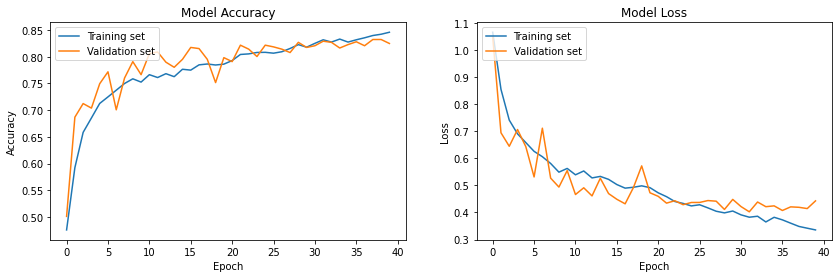

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(mod4_vgg16_history.history['sparse_categorical_accuracy'])
plt.plot(mod4_vgg16_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(mod4_vgg16_history.history['loss'])
plt.plot(mod4_vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

###### Model Predictions

In [ ]:
model_predictions = np.argmax(mod4_vgg16.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9692    0.8077    0.8811       234
           1     0.8211    0.9669    0.8880       242
           2     0.7361    0.7162    0.7260       148

    accuracy                         0.8478       624
   macro avg     0.8421    0.8303    0.8317       624
weighted avg     0.8565    0.8478    0.8470       624



(3.0, 0.0)

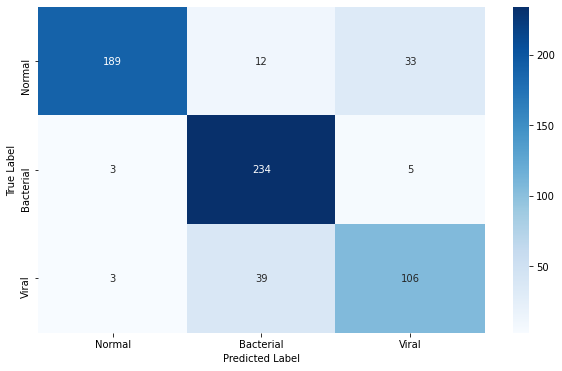

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

##### Training Second Network

In [ ]:
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
mod8_vgg16 = create_vgg16("SGD", lr = 0.0003, momentum = 0.9, trainable = True)
mod8_vgg16_history = mod8_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
                                    epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
                                    validation_data = datagen.flow(x_validation, y_validation), \
                                    callbacks = [learning_rate_reduction])


Epoch 1/40
235/235 [==============================] - 51s 216ms/step - loss: 0.8503 - sparse_categorical_accuracy: 0.5976 - val_loss: 0.6639 - val_sparse_categorical_accuracy: 0.6879
Epoch 2/40
235/235 [==============================] - 49s 209ms/step - loss: 0.6680 - sparse_categorical_accuracy: 0.6923 - val_loss: 0.5837 - val_sparse_categorical_accuracy: 0.7367
Epoch 3/40
235/235 [==============================] - 49s 210ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.7219 - val_loss: 0.6045 - val_sparse_categorical_accuracy: 0.7389
Epoch 4/40
235/235 [==============================] - 49s 207ms/step - loss: 0.5865 - sparse_categorical_accuracy: 0.7403 - val_loss: 0.5396 - val_sparse_categorical_accuracy: 0.7463
Epoch 5/40
235/235 [==============================] - 50s 212ms/step - loss: 0.5556 - sparse_categorical_accuracy: 0.7605 - val_loss: 0.5504 - val_sparse_categorical_accuracy: 0.7665
Epoch 6/40
235/235 [==============================] - 49s 210ms/step - loss: 0.5363 -

###### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , mod8_vgg16.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , mod8_vgg16.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 60ms/step - loss: 0.5335 - sparse_categorical_accuracy: 0.8590
Loss of CNN model is -  0.5334898233413696
20/20 [==============================] - 1s 59ms/step - loss: 0.5335 - sparse_categorical_accuracy: 0.8590
Accuracy of CNN model is -  85.89743375778198 %


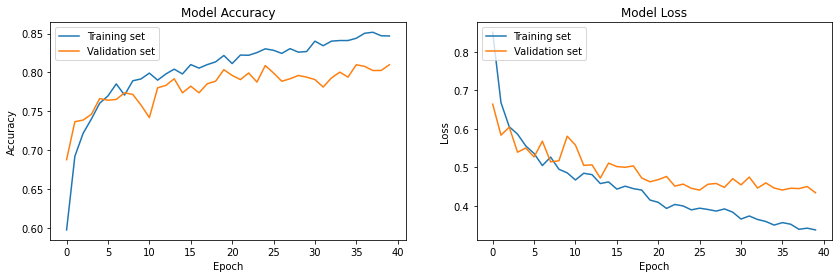

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(mod8_vgg16_history.history['sparse_categorical_accuracy'])
plt.plot(mod8_vgg16_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(mod8_vgg16_history.history['loss'])
plt.plot(mod8_vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

###### Model Predictions

In [ ]:
model_predictions = np.argmax(mod8_vgg16.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits = 4))

              precision    recall  f1-score   support

           0     0.9943    0.7436    0.8509       234
           1     0.8773    0.9752    0.9237       242
           2     0.7000    0.8514    0.7683       148

    accuracy                         0.8590       624
   macro avg     0.8572    0.8567    0.8476       624
weighted avg     0.8791    0.8590    0.8595       624



(3.0, 0.0)

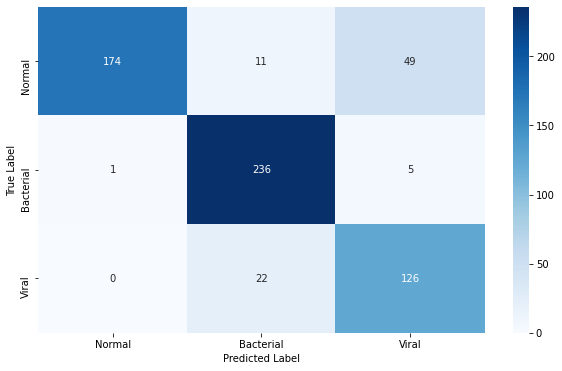

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

##### Training Third Network

In [ ]:
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
mod9_vgg16 = create_vgg16("SGD", lr = 0.0003, momentum = 0.9, trainable = True)
mod9_vgg16_history = mod9_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
                                    epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
                                    validation_data = datagen.flow(x_validation, y_validation), \
                                    callbacks = [learning_rate_reduction])


Epoch 1/40
235/235 [==============================] - 48s 204ms/step - loss: 0.8885 - sparse_categorical_accuracy: 0.5901 - val_loss: 0.6639 - val_sparse_categorical_accuracy: 0.6900
Epoch 2/40
235/235 [==============================] - 46s 196ms/step - loss: 0.6872 - sparse_categorical_accuracy: 0.6864 - val_loss: 0.6747 - val_sparse_categorical_accuracy: 0.6730
Epoch 3/40
235/235 [==============================] - 46s 196ms/step - loss: 0.6233 - sparse_categorical_accuracy: 0.7179 - val_loss: 0.6047 - val_sparse_categorical_accuracy: 0.7240
Epoch 4/40
235/235 [==============================] - 46s 196ms/step - loss: 0.5736 - sparse_categorical_accuracy: 0.7427 - val_loss: 0.5664 - val_sparse_categorical_accuracy: 0.7314
Epoch 5/40
235/235 [==============================] - 46s 195ms/step - loss: 0.5610 - sparse_categorical_accuracy: 0.7536 - val_loss: 0.5421 - val_sparse_categorical_accuracy: 0.7728
Epoch 6/40
235/235 [==============================] - 46s 198ms/step - loss: 0.5380 -

###### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , mod9_vgg16.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , mod9_vgg16.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 59ms/step - loss: 0.4863 - sparse_categorical_accuracy: 0.8718
Loss of CNN model is -  0.4862620532512665
20/20 [==============================] - 1s 59ms/step - loss: 0.4863 - sparse_categorical_accuracy: 0.8718
Accuracy of CNN model is -  87.17948794364929 %


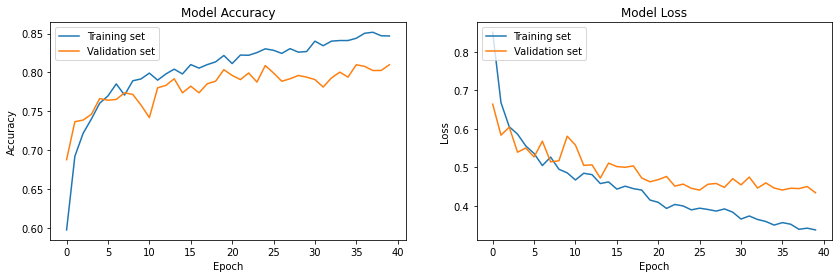

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(mod9_vgg16_history.history['sparse_categorical_accuracy'])
plt.plot(mod9_vgg16_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(mod9_vgg16_history.history['loss'])
plt.plot(mod9_vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

###### Model Predictions

In [ ]:
model_predictions = np.argmax(mod9_vgg16.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits = 4))

              precision    recall  f1-score   support

           0     0.9892    0.7821    0.8735       234
           1     0.8806    0.9752    0.9255       242
           2     0.7310    0.8446    0.7837       148

    accuracy                         0.8718       624
   macro avg     0.8669    0.8673    0.8609       624
weighted avg     0.8858    0.8718    0.8724       624



(3.0, 0.0)

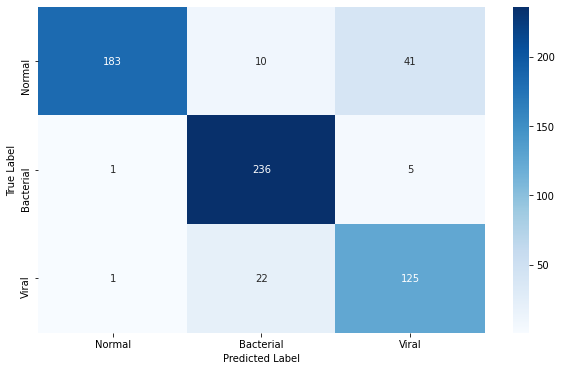

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

##### Training Fourth Network

In [ ]:
x_training, x_validation, y_training, y_validation = train_test_split(x_train, y_train, test_size = 0.2)
mod10_vgg16 = create_vgg16("SGD", lr = 0.0003, momentum = 0.9, trainable = True)
mod10_vgg16_history = mod10_vgg16.fit(datagen.flow(x_training, y_training, batch_size=16), \
                                    epochs = 40, steps_per_epoch = x_training.shape[0]//16, \
                                    validation_data = datagen.flow(x_validation, y_validation), \
                                    callbacks = [learning_rate_reduction])


Epoch 1/40
235/235 [==============================] - 57s 242ms/step - loss: 0.8470 - sparse_categorical_accuracy: 0.6011 - val_loss: 0.6336 - val_sparse_categorical_accuracy: 0.7091
Epoch 2/40
235/235 [==============================] - 55s 235ms/step - loss: 0.6351 - sparse_categorical_accuracy: 0.7045 - val_loss: 0.5884 - val_sparse_categorical_accuracy: 0.7378
Epoch 3/40
235/235 [==============================] - 55s 235ms/step - loss: 0.6066 - sparse_categorical_accuracy: 0.7299 - val_loss: 0.6205 - val_sparse_categorical_accuracy: 0.7304
Epoch 4/40
235/235 [==============================] - 55s 235ms/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7485 - val_loss: 0.5621 - val_sparse_categorical_accuracy: 0.7410
Epoch 5/40
235/235 [==============================] - 55s 233ms/step - loss: 0.5498 - sparse_categorical_accuracy: 0.7653 - val_loss: 0.5321 - val_sparse_categorical_accuracy: 0.7654
Epoch 6/40
235/235 [==============================] - 55s 234ms/step - loss: 0.5176 -

###### Test Accuracy

In [ ]:
y_test = np.squeeze(y_test)

print("Loss of CNN model is - " , mod10_vgg16.evaluate(x_test,y_test)[0])
print("Accuracy of CNN model is - " , mod10_vgg16.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 61ms/step - loss: 0.4291 - sparse_categorical_accuracy: 0.8894
Loss of CNN model is -  0.4290834069252014
20/20 [==============================] - 1s 60ms/step - loss: 0.4291 - sparse_categorical_accuracy: 0.8894
Accuracy of CNN model is -  88.94230723381042 %


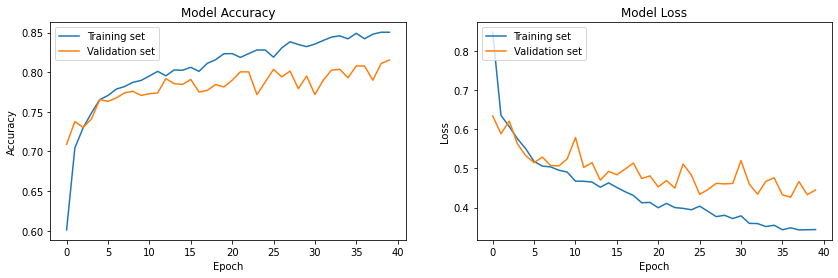

In [ ]:
# Accuracy 

plt.figure(figsize = (14,4))

plt.subplot(1,2,1)
plt.plot(mod10_vgg16_history.history['sparse_categorical_accuracy'])
plt.plot(mod10_vgg16_history.history['val_sparse_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')


# Loss 

plt.subplot(1,2,2)
plt.plot(mod10_vgg16_history.history['loss'])
plt.plot(mod10_vgg16_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')

plt.show()

###### Model Predictions

In [ ]:
model_predictions = np.argmax(mod10_vgg16.predict(x_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, model_predictions, digits = 4))

              precision    recall  f1-score   support

           0     0.9706    0.8462    0.9041       234
           1     0.8736    0.9711    0.9198       242
           2     0.8079    0.8243    0.8161       148

    accuracy                         0.8894       624
   macro avg     0.8840    0.8805    0.8800       624
weighted avg     0.8944    0.8894    0.8893       624



(3.0, 0.0)

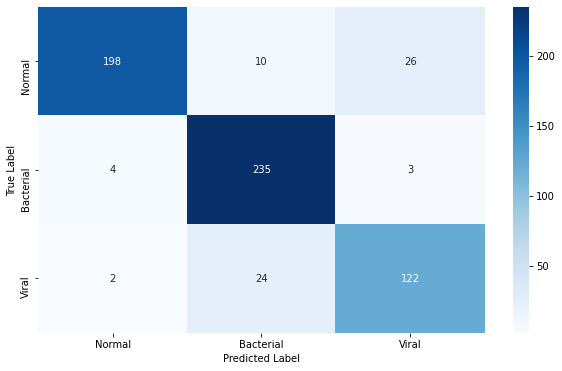

In [ ]:
#confusion_matrix(y_test, model_predictions)

#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, model_predictions)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

### Ensemble - Logistic Regression

Now that we have 6 separate CNN models, we can train a meta-learner that will best combine the predictions from each of the 6 sub-models.

#### Load Models

First, load the 6 models that we saved and perform predictions on the validation set.

In [ ]:
##############
mod2_densenet201 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod2_densenet201_30epochs_acc8253_overfit_sgd.h5")
mod3_densenet201 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod3_densenet201_30epochs_acc8526_overfit_sgd.h5")
mod4_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod4_vgg16_40epochs_acc8478_stable_adam.h5")
mod8_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod8_vgg16_40epochs_acc8590_overfit-stable_sgd.h5")
mod9_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod9_vgg16_40epochs_acc8718_overfit-stable_sgd.h5")
mod10_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod10_vgg16_40epochs_acc8894_overfit-stable_sgd.h5")

#### Collect and Reshape Predictions / Fitting the Classifier 

In [ ]:
mod2_densenet201_val_preds = mod2_densenet201.predict(x_val)
mod3_densenet201_val_preds = mod3_densenet201.predict(x_val)
mod4_vgg16_val_preds = mod4_vgg16.predict(x_val)
mod8_vgg16_val_preds = mod8_vgg16.predict(x_val)
mod9_vgg16_val_preds = mod9_vgg16.predict(x_val)
mod10_vgg16_val_preds = mod10_vgg16.predict(x_val)

print("Confirming array shapes for each set of model predictions:")
print(np.shape(mod2_densenet201_val_preds), np.shape(mod3_densenet201_val_preds), np.shape(mod4_vgg16_val_preds),
      np.shape(mod8_vgg16_val_preds), np.shape(mod9_vgg16_val_preds), np.shape(mod10_vgg16_val_preds))

Confirming array shapes for each set of model predictions:
(524, 3) (524, 3) (524, 3) (524, 3) (524, 3) (524, 3)


Next, using these predictions, we prepare a training set for the meta-learner. Each model outputs three predictions corresponding to the probabilties that a validation image belongs to each of the three classes. Given that we have 6 sub-models and each model makes 3 predictions per image, we would have 18 features for each image. We stack the model predictions together and flatten them into two dimensions.

In [ ]:
stacked_val_preds = np.dstack(( mod2_densenet201_val_preds, mod3_densenet201_val_preds,
                                mod4_vgg16_val_preds, mod8_vgg16_val_preds, mod9_vgg16_val_preds, mod10_vgg16_val_preds
                              ))
np.shape(stacked_val_preds)

(524, 3, 6)

In [ ]:
stacked_val_preds = stacked_val_preds.reshape((stacked_val_preds.shape[0], stacked_val_preds.shape[1]*stacked_val_preds.shape[2]))
np.shape(stacked_val_preds)

(524, 18)

Now that we have set of predictions for each image in the validation set, we can fit a Logistic Regression classifier using the validation labels.

In [ ]:
from sklearn.linear_model import LogisticRegression

LGR_model = LogisticRegression()
LGR_model.fit(stacked_val_preds, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Since our Logistic Regression classifier requires stacked and reshaped arrays for input, we would need to apply the same array transformations on our test dataset as well.

In [ ]:
mod2_densenet201_test_preds = mod2_densenet201.predict(x_test)
mod3_densenet201_test_preds = mod3_densenet201.predict(x_test)
mod4_vgg16_test_preds = mod4_vgg16.predict(x_test)
mod8_vgg16_test_preds = mod8_vgg16.predict(x_test)
mod9_vgg16_test_preds = mod9_vgg16.predict(x_test)
mod10_vgg16_test_preds = mod10_vgg16.predict(x_test)


print(np.shape(mod2_densenet201_test_preds), np.shape(mod3_densenet201_test_preds), np.shape(mod4_vgg16_test_preds), 
      np.shape(mod8_vgg16_test_preds), np.shape(mod9_vgg16_test_preds), np.shape(mod10_vgg16_test_preds))

stacked_test_preds = np.dstack((mod2_densenet201_test_preds, mod3_densenet201_test_preds,
                                mod4_vgg16_test_preds, mod8_vgg16_test_preds, mod9_vgg16_test_preds, mod10_vgg16_test_preds
                                )) 
print(np.shape(stacked_test_preds))

stacked_test_preds = stacked_test_preds.reshape((stacked_test_preds.shape[0], stacked_test_preds.shape[1]*stacked_test_preds.shape[2]))
print(np.shape(stacked_test_preds))

logistic_preds = LGR_model.predict(stacked_test_preds)

(624, 3) (624, 3) (624, 3) (624, 3) (624, 3) (624, 3)
(624, 3, 6)
(624, 18)


Now, we can make predictions using our Logistic Regression classifier on the test dataset.

In [ ]:
logistic_preds = LGR_model.predict(stacked_test_preds)

In [ ]:
#output probability estimates of each prediction

logistic_preds_probs = LGR_model.predict_proba(stacked_test_preds)
logistic_preds_probs = np.max(logistic_preds_probs, axis=1)

#### Classifier Accuracy

Evaluating our model on the test dataset, we achieve improved accuracy! 

In [ ]:
y_test = np.squeeze(y_test)

from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, logistic_preds, digits=4))

              precision    recall  f1-score   support

           0     0.9948    0.8162    0.8967       234
           1     0.8495    0.9793    0.9098       242
           2     0.7582    0.7838    0.7708       148

    accuracy                         0.8718       624
   macro avg     0.8675    0.8598    0.8591       624
weighted avg     0.8823    0.8718    0.8719       624



(3.0, 0.0)

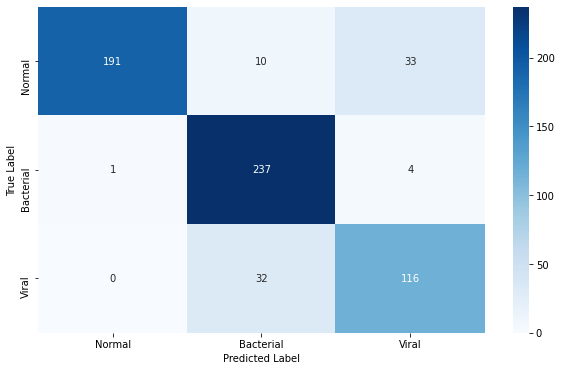

In [ ]:
#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, logistic_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

In [ ]:
correct_predictions = np.nonzero(logistic_preds == y_test)[0]
incorrect_predictions = np.nonzero(logistic_preds != y_test)[0]
print("Incorrect preds:",np.shape(incorrect_predictions))
print("Correct preds:",np.shape(correct_predictions))

Incorrect preds: (80,)
Correct preds: (544,)


#### Standalone Models Accuracy

In [ ]:
#evaluate stand-alone models on test dataset
from sklearn.metrics import accuracy_score

mod2_densenet201_preds = np.argmax(mod2_densenet201.predict(x_test), axis = -1)
mod3_densenet201_preds = np.argmax(mod3_densenet201.predict(x_test), axis = -1)
mod4_vgg16_preds = np.argmax(mod4_vgg16.predict(x_test), axis = -1)
mod8_vgg16_preds = np.argmax(mod8_vgg16.predict(x_test), axis = -1)
mod9_vgg16_preds = np.argmax(mod9_vgg16.predict(x_test), axis = -1)
mod10_vgg16_preds = np.argmax(mod10_vgg16.predict(x_test), axis = -1)

print("Model 1: DenseNet:", accuracy_score(y_test, mod2_densenet201_preds))
print("Model 2: DenseNet:", accuracy_score(y_test, mod3_densenet201_preds))
print("Model 3: VGG16:", accuracy_score(y_test, mod4_vgg16_preds))
print("Model 4: VGG16:", accuracy_score(y_test, mod8_vgg16_preds))
print("Model 5: VGG16:", accuracy_score(y_test, mod9_vgg16_preds))
print("Model 6: VGG16:", accuracy_score(y_test, mod10_vgg16_preds))



Model 1: DenseNet: 0.8253205128205128
Model 2: DenseNet: 0.8525641025641025
Model 3: VGG16: 0.8477564102564102
Model 4: VGG16: 0.8589743589743589
Model 5: VGG16: 0.8717948717948718
Model 6: VGG16: 0.8894230769230769


#### Make Predictions on Images

Let's take a look at which images our ensemble classifier predicted correctly. We can also output the probababilties for each category using sklearn's predict_proba function.

Correctly Classified Normal Lungs:


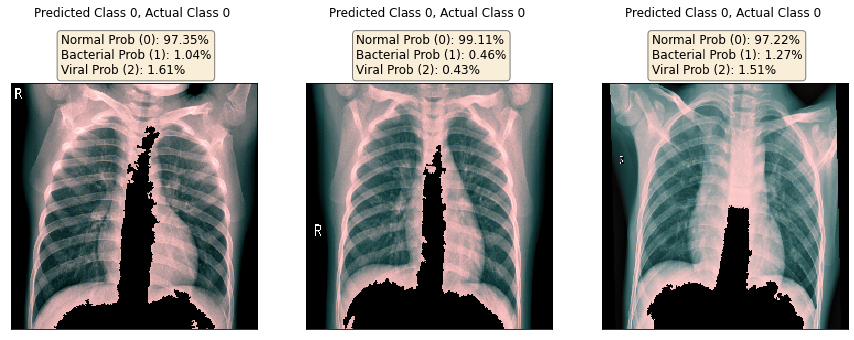

Correctly Classified Lungs with Bacterial Pneumonia:


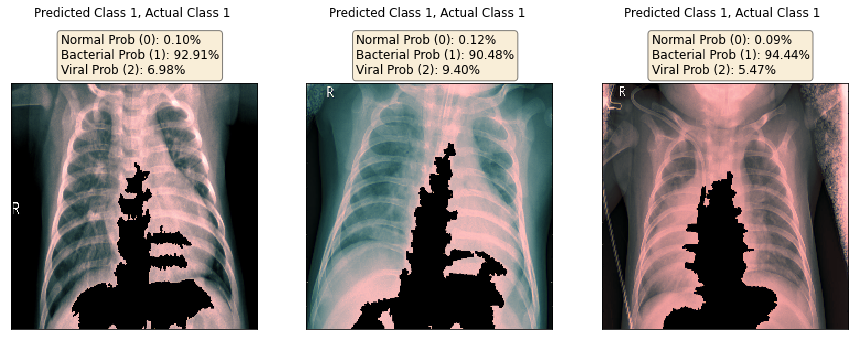

Correctly Classified Lungs with Viral Pneumonia:


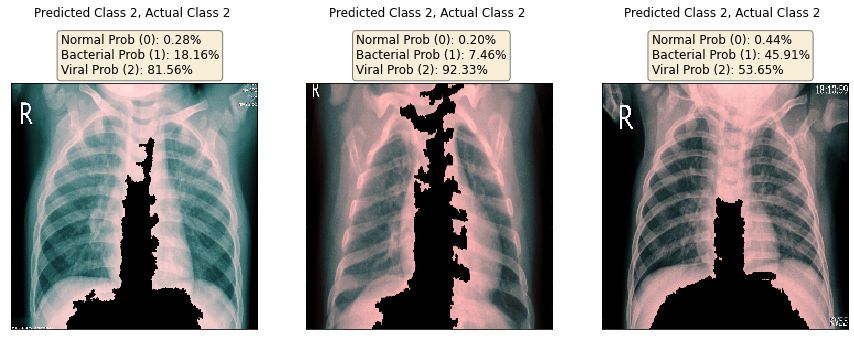

In [ ]:
correct_prediction_actual_0 = ([c for c in correct_predictions if y_test[c] == 0])
correct_prediction_actual_1 = ([c for c in correct_predictions if y_test[c] == 1])
correct_prediction_actual_2 = ([c for c in correct_predictions if y_test[c] == 2])


import random
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#########################################
# Correctly Classified Normal Lungs

plt.figure(figsize = (15,10))

print("Correctly Classified Normal Lungs:")
random_correct_predictions = np.random.choice(correct_prediction_actual_0,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {} \n\n\n\n".format(logistic_preds[c], y_test[c]))
  
  class0_prob = LGR_model.predict_proba(stacked_test_preds)[c][0]
  class1_prob = LGR_model.predict_proba(stacked_test_preds)[c][1]
  class2_prob = LGR_model.predict_proba(stacked_test_preds)[c][2]

  textstr = '\n'.join((
      r'Normal Prob (0): {:.2%}'.format(class0_prob),
      r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
      r'Viral Prob (2): {:.2%}'.format(class2_prob)))
    
  plt.text(45, -45, textstr, verticalalignment = "top", bbox=props, size = "large")

plt.show()

#########################################
# Correctly Classified Lungs with Bacterial Pneumonia

plt.figure(figsize = (15,10))
print("Correctly Classified Lungs with Bacterial Pneumonia:")
random_correct_predictions = np.random.choice(correct_prediction_actual_1,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {} \n\n\n\n".format(logistic_preds[c], y_test[c]))
  
  class0_prob = LGR_model.predict_proba(stacked_test_preds)[c][0]
  class1_prob = LGR_model.predict_proba(stacked_test_preds)[c][1]
  class2_prob = LGR_model.predict_proba(stacked_test_preds)[c][2]

  textstr = '\n'.join((
      r'Normal Prob (0): {:.2%}'.format(class0_prob),
      r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
      r'Viral Prob (2): {:.2%}'.format(class2_prob)))
    
  plt.text(45, -45, textstr, verticalalignment = "top", bbox=props, size = "large")

plt.show()

#########################################
# Correctly Classified Lungs with Viral Pneumonia

plt.figure(figsize = (15,10))
print("Correctly Classified Lungs with Viral Pneumonia:")
random_correct_predictions = np.random.choice(correct_prediction_actual_2,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {} \n\n\n\n".format(logistic_preds[c], y_test[c]))
  
  class0_prob = LGR_model.predict_proba(stacked_test_preds)[c][0]
  class1_prob = LGR_model.predict_proba(stacked_test_preds)[c][1]
  class2_prob = LGR_model.predict_proba(stacked_test_preds)[c][2]

  textstr = '\n'.join((
      r'Normal Prob (0): {:.2%}'.format(class0_prob),
      r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
      r'Viral Prob (2): {:.2%}'.format(class2_prob)))
    
  plt.text(45, -45, textstr, verticalalignment = "top", bbox=props, size = "large")

plt.show()




Let's take a look at the images that our ensemble classifier predicted incorrectly.

Incorrectly Classified Normal Lungs:


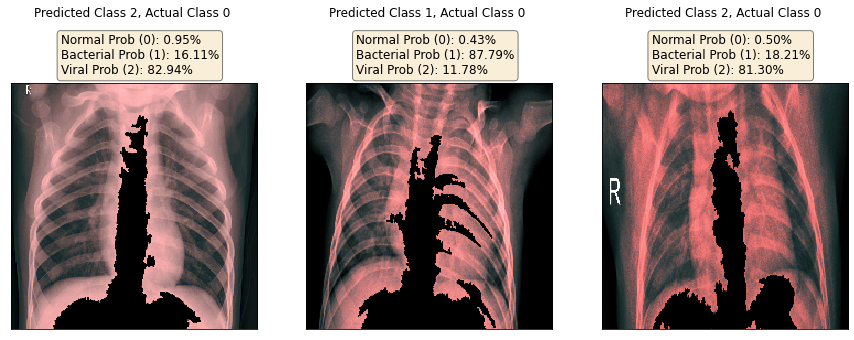

Incorrectly Classified Lungs with Bacterial Pneumonia:


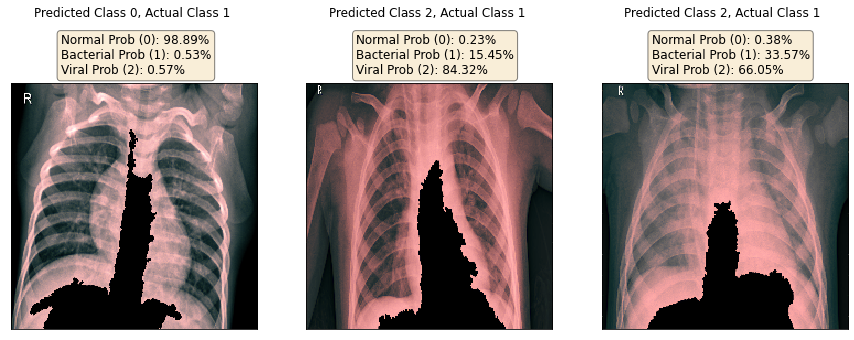

Incorrectly Classified Lungs with Viral Pneumonia:


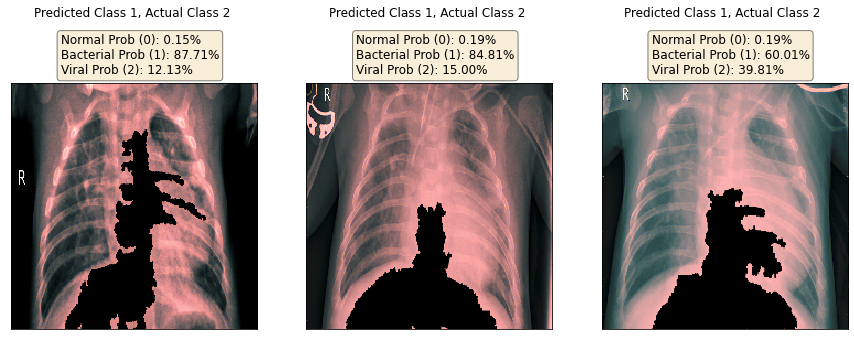

In [ ]:
incorrect_prediction_actual_0 = ([c for c in incorrect_predictions if y_test[c] == 0])
incorrect_prediction_actual_1 = ([c for c in incorrect_predictions if y_test[c] == 1])
incorrect_prediction_actual_2 = ([c for c in incorrect_predictions if y_test[c] == 2])


import random
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#########################################
# Incorrectly Classified Normal Lungs

plt.figure(figsize = (15,10))

print("Incorrectly Classified Normal Lungs:")
random_correct_predictions = np.random.choice(incorrect_prediction_actual_0,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {} \n\n\n\n".format(logistic_preds[c], y_test[c]))
  
  class0_prob = LGR_model.predict_proba(stacked_test_preds)[c][0]
  class1_prob = LGR_model.predict_proba(stacked_test_preds)[c][1]
  class2_prob = LGR_model.predict_proba(stacked_test_preds)[c][2]

  textstr = '\n'.join((
      r'Normal Prob (0): {:.2%}'.format(class0_prob),
      r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
      r'Viral Prob (2): {:.2%}'.format(class2_prob)))
    
  plt.text(45, -45, textstr, verticalalignment = "top", bbox=props, size = "large")

plt.show()

#########################################
# Incorrectly Classified Lungs with Bacterial Pneumonia

plt.figure(figsize = (15,10))
print("Incorrectly Classified Lungs with Bacterial Pneumonia:")
random_correct_predictions = np.random.choice(incorrect_prediction_actual_1,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {} \n\n\n\n".format(logistic_preds[c], y_test[c]))
  
  class0_prob = LGR_model.predict_proba(stacked_test_preds)[c][0]
  class1_prob = LGR_model.predict_proba(stacked_test_preds)[c][1]
  class2_prob = LGR_model.predict_proba(stacked_test_preds)[c][2]

  textstr = '\n'.join((
      r'Normal Prob (0): {:.2%}'.format(class0_prob),
      r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
      r'Viral Prob (2): {:.2%}'.format(class2_prob)))
    
  plt.text(45, -45, textstr, verticalalignment = "top", bbox=props, size = "large")

plt.show()

#########################################
# Incorrectly Classified Lungs with Viral Pneumonia

plt.figure(figsize = (15,10))
print("Incorrectly Classified Lungs with Viral Pneumonia:")
random_correct_predictions = np.random.choice(incorrect_prediction_actual_2,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {} \n\n\n\n".format(logistic_preds[c], y_test[c]))
  
  class0_prob = LGR_model.predict_proba(stacked_test_preds)[c][0]
  class1_prob = LGR_model.predict_proba(stacked_test_preds)[c][1]
  class2_prob = LGR_model.predict_proba(stacked_test_preds)[c][2]

  textstr = '\n'.join((
      r'Normal Prob (0): {:.2%}'.format(class0_prob),
      r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
      r'Viral Prob (2): {:.2%}'.format(class2_prob)))
    
  plt.text(45, -45, textstr, verticalalignment = "top", bbox=props, size = "large")

plt.show()

## Ensemble - Classify by Voting

An alternative to using a meta-learner like Logistic Regression would be to collect the predictions of each model and have them vote. The predicted class that appears most often per image would be selected as the overall prediction. 

#### Load Models

First, load the models and have them perform predictions on the test set.

In [ ]:
mod2_densenet201 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod2_densenet201_30epochs_acc8253_overfit_sgd.h5")
mod3_densenet201 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod3_densenet201_30epochs_acc8526_overfit_sgd.h5")
mod4_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod4_vgg16_40epochs_acc8478_stable_adam.h5")
mod8_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod8_vgg16_40epochs_acc8590_overfit-stable_sgd.h5")
mod9_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod9_vgg16_40epochs_acc8718_overfit-stable_sgd.h5")
mod10_vgg16 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod10_vgg16_40epochs_acc8894_overfit-stable_sgd.h5")

#### Collect and Reshape Predictions

Collect each model's prediction on the test dataset.

In [ ]:
mod2_densenet201_preds = np.argmax(mod2_densenet201.predict(x_test), axis = -1)
mod3_densenet201_preds = np.argmax(mod3_densenet201.predict(x_test), axis = -1)
mod4_vgg16_preds = np.argmax(mod4_vgg16.predict(x_test), axis = -1)
mod8_vgg16_preds = np.argmax(mod8_vgg16.predict(x_test), axis = -1)
mod9_vgg16_preds = np.argmax(mod9_vgg16.predict(x_test), axis = -1)
mod10_vgg16_preds = np.argmax(mod10_vgg16.predict(x_test), axis = -1)


Now, for each combination of model and test image, we collect a prediction and store them into an array. Since we have 6 models and 624 test images, we should have a 624x6 array.

In [ ]:
stacked_preds = []
sub_models = [mod2_densenet201_preds, mod3_densenet201_preds,
             mod4_vgg16_preds, mod8_vgg16_preds, mod9_vgg16_preds, mod10_vgg16_preds]

for i in range(x_test.shape[0]):
  img_pred = []

  for model in sub_models:
    img_pred.append(model[i])

  stacked_preds.append(img_pred)

print(np.shape(stacked_preds))

(624, 6)


Each row in our array contains 6 predictions, each of which is 0, 1, or 2 (Normal, Bacterial, or Viral). For each row, we will only select the prediction that appears most often. If there is a tie, we will collect the prediction that appears first.

In [ ]:
final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacked_preds)
np.shape(final_preds)

(624,)

#### Classifier Accuracy
We achieve better accuracy through voting than our logistic regression meta-model.

In [ ]:
print(classification_report(y_test, final_preds,digits=4))

              precision    recall  f1-score   support

           0     0.9950    0.8462    0.9145       234
           1     0.8628    0.9876    0.9210       242
           2     0.8108    0.8108    0.8108       148

    accuracy                         0.8926       624
   macro avg     0.8895    0.8815    0.8821       624
weighted avg     0.9000    0.8926    0.8924       624



(3.0, 0.0)

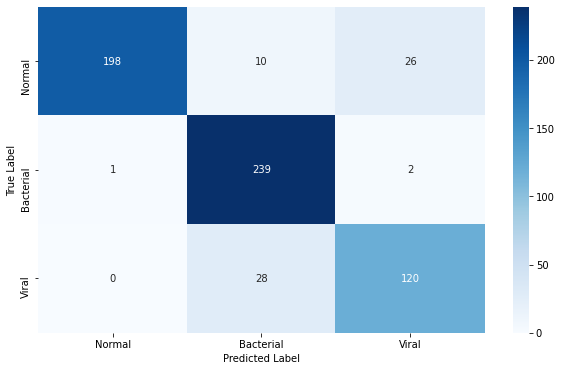

In [ ]:
#fancy confusion matrix plot

import seaborn as sns

index = ['Normal', 'Bacterial', 'Viral']
columns = ['Normal', 'Bacterial', 'Viral']

cm = confusion_matrix(y_test, final_preds)
cm_df = pd.DataFrame(cm, columns, index)
plt.figure(figsize = (10,6))
ax = sns.heatmap(cm_df, annot = True, fmt='d', cmap = "Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
#ax.get_ylim()
ax.set_ylim(3, 0)

In [ ]:
correct_predictions = np.nonzero(final_preds == y_test)[0]
incorrect_predictions = np.nonzero(final_preds != y_test)[0]
print("Incorrect preds:",np.shape(incorrect_predictions))
print("Correct preds:",np.shape(correct_predictions))

Incorrect preds: (67,)
Correct preds: (557,)


#### Standalone Models Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

print("Model 1: DenseNet:", accuracy_score(y_test, mod2_densenet201_preds))
print("Model 2: DenseNet:", accuracy_score(y_test, mod3_densenet201_preds))
print("Model 3: VGG16:", accuracy_score(y_test, mod4_vgg16_preds))
print("Model 4: VGG16:", accuracy_score(y_test, mod8_vgg16_preds))
print("Model 5: VGG16:", accuracy_score(y_test, mod9_vgg16_preds))
print("Model 6: VGG16:", accuracy_score(y_test, mod10_vgg16_preds))

Model 1: DenseNet: 0.8253205128205128
Model 2: DenseNet: 0.8525641025641025
Model 3: VGG16: 0.8477564102564102
Model 4: VGG16: 0.8589743589743589
Model 5: VGG16: 0.8717948717948718
Model 6: VGG16: 0.8894230769230769


#### Make Predictions on Images

Let's take a look at the images that our ensemble classifier predicted correctly.

Correctly Classified Normal Lungs:


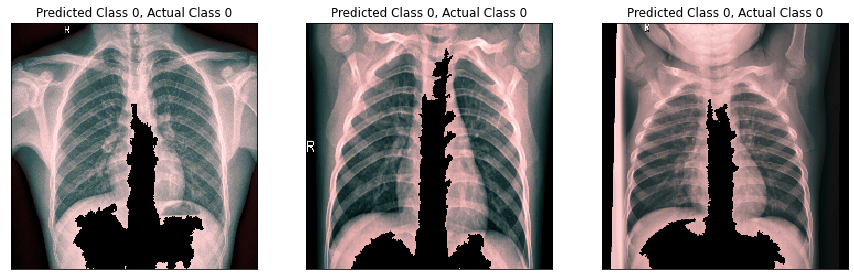

Correctly Classified Lungs with Bacterial Pneumonia:


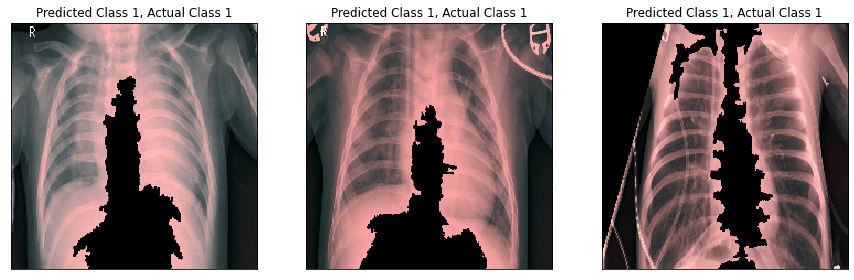

Correctly Classified Lungs with Viral Pneumonia:


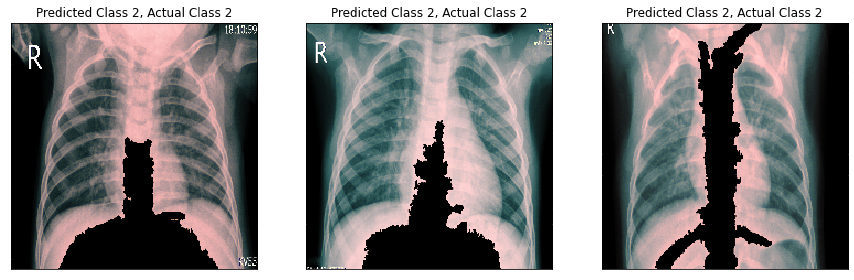

In [ ]:
correct_prediction_actual_0 = ([c for c in correct_predictions if y_test[c] == 0])
correct_prediction_actual_1 = ([c for c in correct_predictions if y_test[c] == 1])
correct_prediction_actual_2 = ([c for c in correct_predictions if y_test[c] == 2])


import random
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#########################################
# Correctly Classified Normal Lungs

plt.figure(figsize = (15,10))

print("Correctly Classified Normal Lungs:")
random_correct_predictions = np.random.choice(correct_prediction_actual_0,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {}".format(final_preds[c], y_test[c]))
  
plt.show()

#########################################
# Correctly Classified Lungs with Bacterial Pneumonia

plt.figure(figsize = (15,10))
print("Correctly Classified Lungs with Bacterial Pneumonia:")
random_correct_predictions = np.random.choice(correct_prediction_actual_1,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {}".format(final_preds[c], y_test[c]))
  
plt.show()

#########################################
# Correctly Classified Lungs with Viral Pneumonia

plt.figure(figsize = (15,10))
print("Correctly Classified Lungs with Viral Pneumonia:")
random_correct_predictions = np.random.choice(correct_prediction_actual_2,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {}".format(final_preds[c], y_test[c]))
  
plt.show()


Let's take a look at the images that our classifier predicted incorrectly.

Incorrectly Classified Normal Lungs:


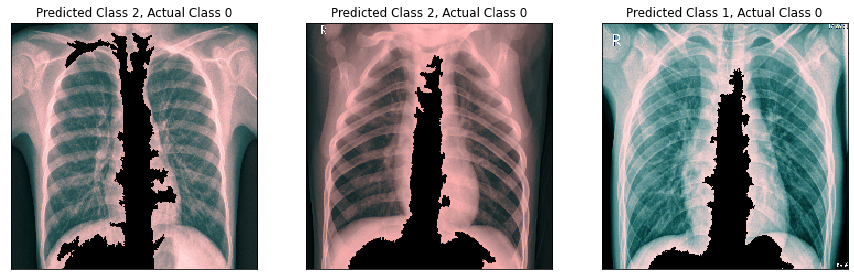

Incorrectly Classified Lungs with Bacterial Pneumonia:


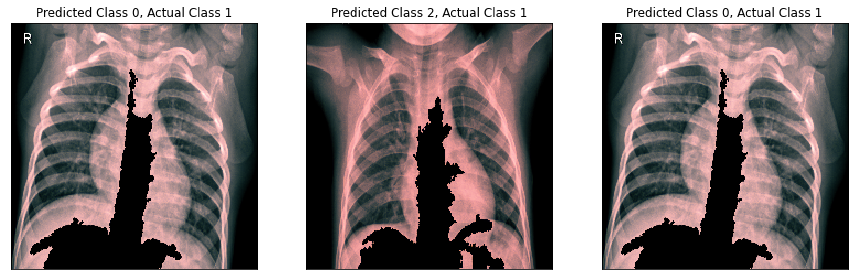

Incorrectly Classified Lungs with Viral Pneumonia:


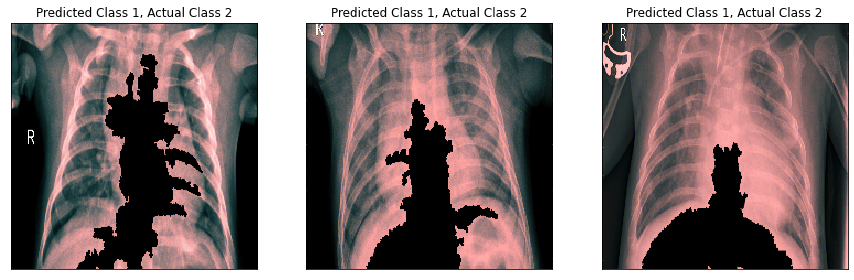

In [ ]:
incorrect_prediction_actual_0 = ([c for c in incorrect_predictions if y_test[c] == 0])
incorrect_prediction_actual_1 = ([c for c in incorrect_predictions if y_test[c] == 1])
incorrect_prediction_actual_2 = ([c for c in incorrect_predictions if y_test[c] == 2])


import random
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

#########################################
# Incorrectly Classified Normal Lungs

plt.figure(figsize = (15,10))

print("Incorrectly Classified Normal Lungs:")
random_correct_predictions = np.random.choice(incorrect_prediction_actual_0,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {}".format(final_preds[c], y_test[c]))

plt.show()

#########################################
# Incorrectly Classified Lungs with Bacterial Pneumonia

plt.figure(figsize = (15,10))
print("Incorrectly Classified Lungs with Bacterial Pneumonia:")
random_correct_predictions = np.random.choice(incorrect_prediction_actual_1,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {}".format(final_preds[c], y_test[c]))

plt.show()

#########################################
# Incorrectly Classified Lungs with Viral Pneumonia

plt.figure(figsize = (15,10))
print("Incorrectly Classified Lungs with Viral Pneumonia:")
random_correct_predictions = np.random.choice(incorrect_prediction_actual_2,3)
for i,c in enumerate(random_correct_predictions):
  i +=1
  plt.subplot(1,3,i)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(x_test[c].reshape(224,224,3), cmap = "gray", interpolation = "none")
  plt.title("Predicted Class {}, Actual Class {}".format(final_preds[c], y_test[c]))

plt.show()

# Future Improvements

Although we were able to achieve almost 90% accuracy on the test dataset, we do not know if our classifier can generalize to new data beyond this Kaggle dataset. For example, in the Image Pipeline implementation below, we tried to classify x-ray images found online, but our classifier were not able to correctly predict their diagnosis.

If we can overcome our computational constraints, we can look into implementing bagging or k-fold cross validation to see if we can improve upon DenseNet or VGG16.

Future work can also involve using GridSearch into finding the best hyperparameters like learning rate, batch size, epochs, momentum, activation functions, dropout rates, fine-tune parameters for image data generator etc.

Our diaphragm removal preprocessing algorithm is not perfect either. Perhaps we can consider lung segmentation instead so we do not have to worry about the skeletal structure and the brightness of pixels in the image. Lung segmentation can be implemented using CNN via U-Net.

Finally, we can explore other methods for ensembles for CNNs, such as an integrated stacking model in which we can use neural networks as a meta-learner.


Links:


https://analyticsindiamag.com/hands-on-guide-to-create-ensemble-of-convolutional-neural-networks/

https://machinelearningmastery.com/stacking-ensemble-for-deep-learning-neural-networks/

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

https://machinelearningmastery.com/how-to-create-a-random-split-cross-validation-and-bagging-ensemble-for-deep-learning-in-keras/

https://github.com/zhixuhao/unet


# Image Pipeline

The following main() function allows you to upload an x-ray image and run it against our ensemble classifier with logistic regression.

### Define Functions

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import keras
from tqdm.notebook import tqdm
tqdm().pandas()
from keras.models import Model
from sklearn.linear_model import LogisticRegression


In [ ]:
#from progressbar import *


def get_training_data_preprocessing():
    from google.colab import files
    import time
    from keras.preprocessing.image import img_to_array
    import copy
    img_size = 224   

    data = []

    path = files.upload()
    path = list(path.keys())[0]

    with tqdm(total = 7) as pbar:
      
          pbar.set_description("processing {} ".format(path))

          try:
              img_arr = cv2.imread(path)   
              total_area = img_arr.size
              #print("Total area:", total_area)

              gray = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)

              gray_copy = copy.deepcopy(gray)

              #get binary image by setting a certain threshold
              #write a while loop that'll find best threshold for each image? 
              #set an area threshold as well?

              gray_binarized = copy.deepcopy(gray)
              gray_r = gray_binarized.reshape(gray_binarized.shape[0] * gray_binarized.shape[1])
              
              pbar.set_description("finding diaphragm region to segment...")
              pbar.update(1)

              threshold_param = 0.85

              while threshold_param <= 0.85:
                  gray_r_copy = copy.deepcopy(gray_r)
                  #print("threshold param:", threshold_param)          
                  threshold = gray_r_copy.min() + threshold_param * (gray_r_copy.max() - gray_r_copy.min())  #default baseline 73
                  #print("calculated threshold:", threshold)
                  for j in range(gray_r_copy.shape[0]):
                      if gray_r_copy[j] > threshold:
                          gray_r_copy[j] = 1
                      else:
                          gray_r_copy[j] = 0

                  gray_binary = gray_r_copy.reshape(gray_binarized.shape[0], gray_binarized.shape[1])

                  #select biggest segmented region
                  mask = np.zeros(gray_binary.shape, np.uint8)

                  contours, hier = cv2.findContours(gray_binary.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
                  largest_area = sorted(contours, key=cv2.contourArea)[-1]

                  cv2.drawContours(mask, [largest_area], 0, (255,255,255,255), -1)
                  segmented_region = cv2.bitwise_and(gray_binary, mask)

                  #print("largest area:", cv2.contourArea(largest_area))
                  
                  if cv2.contourArea(largest_area)/total_area > 0.04:  #diaphragm is approx 3% of total area?
                  #if cv2.contourArea(largest_area) > 130000:
#                             threshold_param += 0.01  #oops went too far, revert back
#                             gray_r_copy = copy.deepcopy(gray_r)
#                             threshold = gray_r_copy.min() + threshold_param * (gray_r_copy.max() - gray_r_copy.min())
#                             for j in range(gray_r_copy.shape[0]):
#                                 if gray_r_copy[j] > threshold:
#                                     gray_r_copy[j] = 1
#                                 else:
#                                     gray_r_copy[j] = 0
#                             gray_binary = gray_r_copy.reshape(gray_binarized.shape[0], gray_binarized.shape[1])
#                             mask = np.zeros(gray_binary.shape, np.uint8)
#                             contours, hier = cv2.findContours(gray_binary.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
#                             largest_area = sorted(contours, key=cv2.contourArea)[-1]
#                             cv2.drawContours(mask, [largest_area], 0, (255,255,255,255), -1)
#                             segmented_region = cv2.bitwise_and(gray_binary, mask)
                      break
                  else:
                      #print("ratio of segmented to total area:", cv2.contourArea(largest_area)/total_area)
                      threshold_param -= 0.01

              pbar.set_description("applying morphological filter...")
              pbar.update(1)
              time.sleep(0.5)
              
              #print(cv2.contourArea(largest_area))

              #apply morphological filtering...dilation
              kernel = np.ones((5,5), np.uint8)
              dilation = cv2.dilate(segmented_region, kernel, iterations = 1)

              pbar.set_description("subtracting dilated contour from original image...")
              pbar.update(1)
              time.sleep(0.5)

              #subtract the dilated contour from the original image
              contours_dilation, hier_dilation = cv2.findContours(dilation.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
              largest_area_dilation = sorted(contours_dilation, key=cv2.contourArea)[-1]

              pbar.set_description("applying histogram equalization...")
              pbar.update(1)
              time.sleep(0.5)

              for contour in contours_dilation:
                  gray_removed_diaphgram = cv2.drawContours(gray_copy, [(contour)], -1, (0,255,255), -1)    #this will be the new Green channel

              #apply histogram equalization to gray removed diaphragm
              gray_removed_diaphgram_equ = cv2.equalizeHist(gray_removed_diaphgram)    #this will be the new Red channel
              
              pbar.set_description("applying bilateral filtering...")
              pbar.update(1)
              time.sleep(0.5)

              #apply bilateral filtering to gray removed diaphragm
              gray_removed_diaphgram_bifilter = cv2.bilateralFilter(gray_removed_diaphgram, 15, 75, 75)   #this will be the new Blue channel
              
              pbar.set_description("output new 3 channel RGB image...")
              pbar.update(1)
              time.sleep(0.5)

              #output new 3 channel RGB image
              new_img = cv2.merge((gray_removed_diaphgram_equ, gray_removed_diaphgram, gray_removed_diaphgram_bifilter ))
              pbar.update(1)

              #plt.figure(figsize=(10,10))
              #plt.subplot(1,2,1)
              plt.figure(figsize=(5,5))
              plt.imshow(img_arr, cmap = 'gray')                
              plt.title('Original Image')
              plt.xticks([])
              plt.yticks([])
    
              # plt.subplot(1,2,2)
              # plt.imshow(new_img, cmap = 'gray')                
              # plt.title('Processed Image \nDiaphragm Removed with New RGB Channels')
              # plt.xticks([])
              # plt.yticks([])
              # plt.show()


              resized_arr = cv2.resize(new_img, (img_size, img_size))     #resize the image to 224x224 array
              resized_arr = np.expand_dims(resized_arr, axis=0)           # resize to (1,224,224,3) array
          except Exception as e:
              print(e)
          #pbar.update(1)

    return np.array(resized_arr)

In [ ]:
def load_models():
  import pickle

  print("Loading model 1...")
  mod1 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod2_densenet201_30epochs_acc8253_overfit_sgd.h5")
  print("Loading model 2...")
  mod2 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod3_densenet201_30epochs_acc8526_overfit_sgd.h5")
  print("Loading model 3...")
  mod3 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod4_vgg16_40epochs_acc8478_stable_adam.h5")
  print("Loading model 4...")
  mod4 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod8_vgg16_40epochs_acc8590_overfit-stable_sgd.h5")
  print("Loading model 5...")
  mod5 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod9_vgg16_40epochs_acc8718_overfit-stable_sgd.h5")
  print("Loading model 6...")
  mod6 = keras.models.load_model("final_model_weights/apples_to_apples_test_set/mod10_vgg16_40epochs_acc8894_overfit-stable_sgd.h5")

  print("Loading logistic regression model...")
  filename = "final_model_weights/apples_to_apples_test_set/logistic_regression_model.sav"
  lgr_clf = pickle.load(open(filename, 'rb'))

  return mod1, mod2, mod3, mod4, mod5, mod6, lgr_clf

In [ ]:
def create_predictions(input_image):
  import tensorflow as tf
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

  mod1_preds = np.argmax(mod1.predict(input_image), axis = -1)
  mod2_preds = np.argmax(mod2.predict(input_image), axis = -1)
  mod3_preds = np.argmax(mod3.predict(input_image), axis = -1)
  mod4_preds = np.argmax(mod4.predict(input_image), axis = -1)
  mod5_preds = np.argmax(mod5.predict(input_image), axis = -1)
  mod6_preds = np.argmax(mod6.predict(input_image), axis = -1)

  stacked_preds = []
  sub_models = [mod1_preds, mod2_preds, mod3_preds, 
                  mod4_preds, mod5_preds, mod6_preds]
  
  for model in sub_models:
    stacked_preds.append(model)


  final_preds = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=stacked_preds)

  if final_preds[0] == 0:
    prediction = "Normal"
  elif final_preds[0] == 1:
    prediction = "Bacterial Pneumonia"
  else:
    prediction = "Viral Pneumonia"

  print("Ensemble by Voting:")
  print("Prediction: {}".format(prediction))

  logistic_regression_pred(input_image)



In [ ]:
def logistic_regression_pred(input_image):
  import tensorflow as tf

  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

  mod1_test_preds = mod1.predict(input_image)
  mod2_test_preds = mod2.predict(input_image)
  mod3_test_preds = mod3.predict(input_image)
  mod4_test_preds = mod4.predict(input_image)
  mod5_test_preds = mod5.predict(input_image)
  mod6_test_preds = mod6.predict(input_image)


  stacked_test_preds = np.dstack((mod1_test_preds, mod2_test_preds, mod3_test_preds, mod4_test_preds, mod5_test_preds, mod6_test_preds))

  stacked_test_preds = stacked_test_preds.reshape((stacked_test_preds.shape[0], stacked_test_preds.shape[1]*stacked_test_preds.shape[2]))

  logistic_preds = lgr_clf.predict(stacked_test_preds)


  if logistic_preds[0] == 0:
    prediction = "Normal"
  elif logistic_preds[0] == 1:
    prediction = "Bacterial Pneumonia"
  else:
    prediction = "Viral Pneumonia"

  class0_prob = lgr_clf.predict_proba(stacked_test_preds)[0][0]
  class1_prob = lgr_clf.predict_proba(stacked_test_preds)[0][1]
  class2_prob = lgr_clf.predict_proba(stacked_test_preds)[0][2]

#####
  plt.figure(figsize=(5,5))
  plt.imshow(np.squeeze(input_image), cmap = 'gray')                
  plt.title('Processed Image \nDiaphragm Removed with New RGB Channels')
  plt.xticks([])
  plt.yticks([])
  

  textstr = '\n'.join((
    r'Normal Prob (0): {:.2%}'.format(class0_prob),
    r'Bacterial Prob (1): {:.2%}'.format(class1_prob),
    r'Viral Prob (2): {:.2%}'.format(class2_prob)))

  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

  plt.text(250, 20, textstr, verticalalignment = "top", bbox=props, size = "large")
  plt.show()
#####
  print("Ensemble by Logistic Regression:")
  print("Prediction: {}".format(prediction))


## Test Drive

In [ ]:
def main():
  global mod1, mod2, mod3, mod4, mod5, mod6, lgr_clf
  mod1, mod2, mod3, mod4, mod5, mod6, lgr_clf = load_models()
  pp_image = get_training_data_preprocessing()
  create_predictions(pp_image)


Loading model 1...
Loading model 2...
Loading model 3...
Loading model 4...
Loading model 5...
Loading model 6...
Loading logistic regression model...


Saving test_image_online.jpeg to test_image_online (2).jpeg



Ensemble by Voting:
Prediction: Bacterial Pneumonia


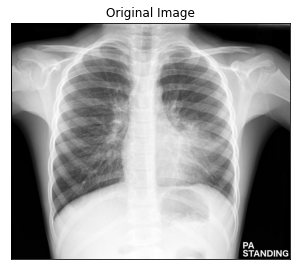

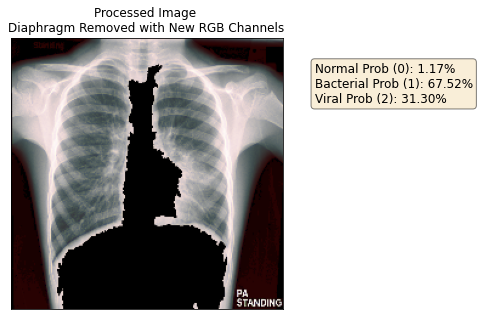

Ensemble by Logistic Regression:
Prediction: Bacterial Pneumonia


In [ ]:
main()

Loading model 1...
Loading model 2...
Loading model 3...
Loading model 4...
Loading model 5...
Loading model 6...
Loading logistic regression model...


Saving test_image_online_viral.jpeg to test_image_online_viral (1).jpeg



Ensemble by Voting:
Prediction: Bacterial Pneumonia


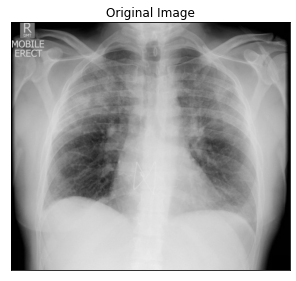

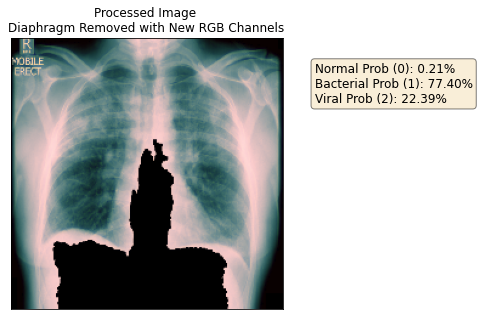

Ensemble by Logistic Regression:
Prediction: Bacterial Pneumonia


In [ ]:
main()

Loading model 1...
Loading model 2...
Loading model 3...
Loading model 4...
Loading model 5...
Loading model 6...
Loading logistic regression model...


Saving test_image_online_viral_2.jpg to test_image_online_viral_2 (1).jpg



Ensemble by Voting:
Prediction: Bacterial Pneumonia


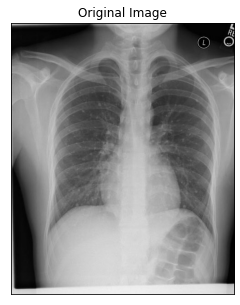

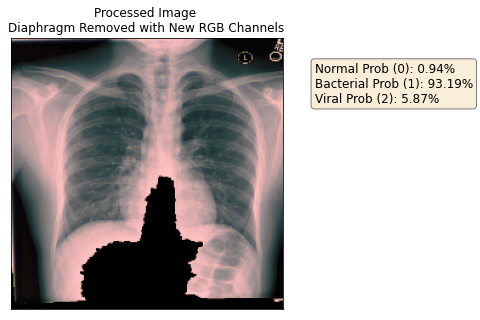

Ensemble by Logistic Regression:
Prediction: Bacterial Pneumonia


In [ ]:
main()

Loading model 1...
Loading model 2...
Loading model 3...
Loading model 4...
Loading model 5...
Loading model 6...
Loading logistic regression model...


Saving test_image_online_normal.jpeg to test_image_online_normal.jpeg



Ensemble by Voting:
Prediction: Bacterial Pneumonia


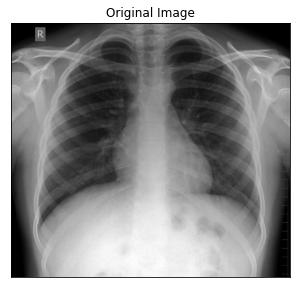

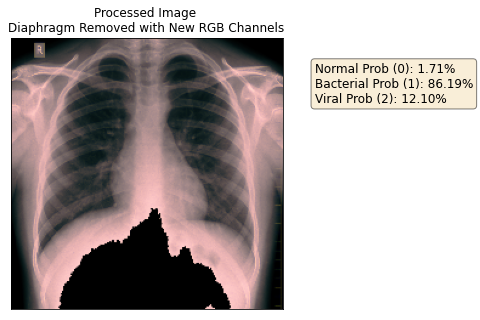

Ensemble by Logistic Regression:
Prediction: Bacterial Pneumonia


In [ ]:
main()